In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Forecasting USD/TRY Exchange Rate using News and CBRT Data

**Student ID:** 211805018
**Dataset ID:** ExchangeRateForecasting

This notebook addresses the second project assignment: forecasting the USD/TRY exchange rate by combining Turkish news articles and historical exchange rate data from the Central Bank of the Republic of Turkiye (CBRT). This is a regression problem that will involve Natural Language Processing (NLP) for feature extraction from text and time-series analysis techniques.

The project will follow the general requirements and the specific instructions provided for this dataset, including the use of a sliding window approach.

**Main Sections in this Notebook:**
1.  Preparation, Library Imports, and Data Loading
2.  Exploratory Data Analysis (EDA) of Combined Data
3.  Feature Extraction (Text NLP, Exchange Rate Features) and Sliding Window Implementation
4.  Data Splitting (Chronological) and Preprocessing (Scaling)
5.  Model Training (Regression Models), Selection (Time-Series CV), and Evaluation
6.  Visualizations (Actual vs. Predicted, Feature Importances, etc.)
7.  Reporting of Results and Conclusion
---

---
## STAGE 1: PREPARATION AND DATA LOADING

In this initial stage, we will set up the environment for our exchange rate forecasting project. This involves:
*   Importing necessary Python libraries, including those for data manipulation, NLP, and machine learning.
*   Defining global constants like `RANDOM_SEED` and the dataset directory.
*   Loading the two separate datasets: Turkish news articles and CBRT USD/TRY exchange rates.
*   Merging these datasets based on the `Date` column.
---

### 1.1 Importing Necessary Libraries

This cell imports the libraries required for data handling, text processing, model building, and evaluation.
- Core libraries: `numpy`, `pandas`, `matplotlib.pyplot`, `seaborn`, `os`, `datetime`.
- NLP libraries: `nltk` (for stopwords, tokenization), `sklearn.feature_extraction.text` (for TF-IDF).
  *Note: Depending on the chosen NLP techniques, libraries like `spacy` (for advanced tokenization, lemmatization in Turkish), `gensim` (for Word2Vec), or even `transformers` might be considered later, but we'll start with basics.*
- Scikit-learn for models and metrics: `train_test_split`, `TimeSeriesSplit`, `StandardScaler`, various regression models (`LinearRegression`, `RandomForestRegressor`, etc.), and regression metrics (`mean_absolute_error`, `r2_score`, `mean_absolute_percentage_error`).

In [ ]:
# Core Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
import time # For measuring execution times

# NLP Libraries
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
# nltk.download('stopwords') # Uncomment and run once if you haven't downloaded stopwords
# nltk.download('punkt') # Uncomment and run once for tokenizer

# Scikit-learn Modules
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error

# For saving the model
import joblib

# Visualization Settings
%matplotlib inline
sns.set_theme(style="whitegrid")
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
# To suppress warnings that are not critical (use with caution)
import warnings
# warnings.filterwarnings('ignore') # Can be useful for cleaner output, but be aware of what's suppressed

print("Necessary libraries imported successfully.")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"NLTK version: {nltk.__version__}")
import sklearn
print(f"Scikit-learn version: {sklearn.__version__}")

Necessary libraries imported successfully.
NumPy version: 2.0.2
Pandas version: 2.2.2
NLTK version: 3.9.1
Scikit-learn version: 1.6.1


### 1.2 Global Settings and Constants

This cell defines some global constants and settings that will be used throughout this project.
- `RANDOM_SEED`: Set to `13` for reproducibility in any operations involving randomness (though less critical in strict time-series splits if not shuffling).
- `DATASET_DIR`: The directory path to the 'Article' folder containing the news and exchange rate CSV files.
- `NEWS_FILE_NAME`: The name of the CSV file containing the Turkish news articles.
- `RATE_FILE_NAME`: The name of the CSV file containing the CBRT USD/TRY exchange rates.
- `TARGET_COL_NAME`: The name of the column representing the USD/TRY exchange rate, which we aim to predict.

In [ ]:
# Constant Values
RANDOM_SEED = 13
DATASET_DIR = "/content/drive/MyDrive/Colab Notebooks/Article/"  # Path to your 'Article' folder on Google Drive

# --- YOU NEED TO PROVIDE THE ACTUAL FILENAMES FOR YOUR CSVs ---
# Replace 'your_news_data.csv' and 'your_rate_data.csv' with the actual filenames
NEWS_FILE_NAME = "TurkishNewsArticles.csv"  # Example: Replace with your actual news CSV filename
RATE_FILE_NAME = "EVDS.csv"   # Example: Replace with your actual exchange rate CSV filename
# --- END OF FILENAME SPECIFICATION ---

TARGET_COL_NAME = 'USD/TRY' # This is based on the problem description, verify from your CBRT data CSV

print(f"Random Seed: {RANDOM_SEED}")
print(f"Dataset Directory: {DATASET_DIR}")
print(f"News Data File (Assumed): {NEWS_FILE_NAME}")
print(f"Exchange Rate Data File (Assumed): {RATE_FILE_NAME}")
print(f"Target Column Name: {TARGET_COL_NAME}")

Random Seed: 13
Dataset Directory: /content/drive/MyDrive/Colab Notebooks/Article/
News Data File (Assumed): TurkishNewsArticles.csv
Exchange Rate Data File (Assumed): EVDS.csv
Target Column Name: USD/TRY


### 1.3 Loading and Merging Datasets

In this step, we will load the Turkish news articles CSV and the CBRT USD/TRY exchange rate CSV. After loading, we will merge them based on their respective date columns. It's crucial to ensure that the date columns are in a consistent `datetime` format before merging.

In [ ]:
# Cell 1.3: Loading and Merging Datasets (Fully Updated based on your CSV structures)

# Ensure necessary variables from Cell 1.2 are available:
# DATASET_DIR, NEWS_FILE_NAME, RATE_FILE_NAME, TARGET_COL_NAME

# Construct full file paths
news_file_path = os.path.join(DATASET_DIR, NEWS_FILE_NAME)
rate_file_path = os.path.join(DATASET_DIR, RATE_FILE_NAME)

df_merged = pd.DataFrame() # Initialize df_merged to handle potential errors gracefully

try:
    # Load the news articles data
    df_news = pd.read_csv(news_file_path)
    print(f"Successfully loaded news data from: {NEWS_FILE_NAME}")
    print(f"News data shape: {df_news.shape}")
    print("First 5 rows of news data (df_news.head()):")
    display(df_news.head())
    print("\nNews data info (df_news.info()):")
    df_news.info()

    # Load the exchange rate data
    df_rates = pd.read_csv(rate_file_path)
    print(f"\nSuccessfully loaded exchange rate data from: {RATE_FILE_NAME}")
    print(f"Exchange rate data shape: {df_rates.shape}")
    print("First 5 rows of exchange rate data (df_rates.head()):")
    display(df_rates.head())
    print("\nExchange rate data info (df_rates.info()):")
    df_rates.info()

    # --- Data Preprocessing and Merging ---

    # 1. Standardize Date Column for News Data
    news_date_col_original = 'date' # Actual column name in TurkishNewsArticles.csv
    if news_date_col_original not in df_news.columns:
        raise KeyError(f"News date column '{news_date_col_original}' not found in df_news. Columns: {df_news.columns.tolist()}")

    def parse_turkish_news_date(date_str):
        try:
            date_part = str(date_str).split(',')[0].strip()
            turkish_months = {
                'Ocak': 'January', 'Şubat': 'February', 'Mart': 'March', 'Nisan': 'April',
                'Mayıs': 'May', 'Haziran': 'June', 'Temmuz': 'July', 'Ağustos': 'August',
                'Eylül': 'September', 'Ekim': 'October', 'Kasım': 'November', 'Aralık': 'December'
            }
            for tr_month, en_month in turkish_months.items():
                if tr_month in date_part:
                    date_part = date_part.replace(tr_month, en_month)
                    break
            return pd.to_datetime(date_part, format='%d %B %Y', errors='coerce')
        except Exception:
            return pd.NaT

    df_news['Date'] = df_news[news_date_col_original].apply(parse_turkish_news_date)
    # Drop original non-standard date column if it's different from 'Date' and successfully converted
    if news_date_col_original != 'Date':
        df_news.drop(columns=[news_date_col_original], inplace=True)

    # Drop rows where date parsing failed for news data
    initial_news_rows = len(df_news)
    df_news.dropna(subset=['Date'], inplace=True)
    print(f"\nNews data 'Date' column processed. {initial_news_rows - len(df_news)} rows dropped due to date parsing errors.")


    # 2. Standardize Date and Target Columns for Exchange Rate Data
    rate_date_col_original = 'Tarih' # Actual column name in EVDS.csv
    usd_try_col_original = 'TP DK USD A YTL' # Actual USD/TRY column name in EVDS.csv

    if rate_date_col_original not in df_rates.columns:
        raise KeyError(f"Rate date column '{rate_date_col_original}' not found in df_rates. Columns: {df_rates.columns.tolist()}")
    if usd_try_col_original not in df_rates.columns:
        raise KeyError(f"USD/TRY column '{usd_try_col_original}' not found in df_rates. Columns: {df_rates.columns.tolist()}")

    df_rates_processed = df_rates[[rate_date_col_original, usd_try_col_original]].copy()
    df_rates_processed.rename(columns={rate_date_col_original: 'Date',
                                       usd_try_col_original: TARGET_COL_NAME}, # TARGET_COL_NAME is 'USD/TRY'
                              inplace=True)

    df_rates_processed['Date'] = pd.to_datetime(df_rates_processed['Date'], format='%d-%m-%Y', errors='coerce')
    df_rates_processed[TARGET_COL_NAME] = pd.to_numeric(df_rates_processed[TARGET_COL_NAME], errors='coerce')

    # Drop rows where date parsing or numeric conversion failed for rates data
    initial_rates_rows = len(df_rates_processed)
    df_rates_processed.dropna(subset=['Date', TARGET_COL_NAME], inplace=True) # Drop if Date OR USD/TRY is NaN
    print(f"Exchange rate data processed. {initial_rates_rows - len(df_rates_processed)} rows dropped due to date/rate parsing errors or NaN rates.")
    print(f"Processed exchange rate data (df_rates_processed.head()):")
    display(df_rates_processed.head())
    print("\nInfo of processed exchange rate data:")
    df_rates_processed.info()


    # 3. Merge the two DataFrames
    df_news = df_news.sort_values(by='Date')
    df_rates_processed = df_rates_processed.sort_values(by='Date').drop_duplicates(subset=['Date'], keep='last')

    # Perform the merge: left merge on news data to keep all news, and attach corresponding rate.
    df_merged = pd.merge(df_news, df_rates_processed, on='Date', how='left')

    print(f"\nMerged data shape: {df_merged.shape}")
    print("First 5 rows of merged data (df_merged.head()):")
    display(df_merged.head())
    print("\nInfo of merged data (df_merged.info()):")
    df_merged.info()

    # Check NaNs in the target column after merge
    if TARGET_COL_NAME in df_merged.columns:
        nan_in_target = df_merged[TARGET_COL_NAME].isnull().sum()
        print(f"\nNumber of NaN values in '{TARGET_COL_NAME}' after left merge: {nan_in_target}")
        if nan_in_target > 0:
            print("These NaNs occur for news dates where no corresponding exchange rate was found (e.g., weekends/holidays for rates).")
            print("Applying forward fill (ffill) to propagate last known rate to these dates...")
            df_merged[TARGET_COL_NAME] = df_merged[TARGET_COL_NAME].ffill()
            nan_after_ffill = df_merged[TARGET_COL_NAME].isnull().sum()
            print(f"Number of NaN values in '{TARGET_COL_NAME}' after ffill: {nan_after_ffill}")
            if nan_after_ffill > 0:
                print("Remaining NaNs after ffill (likely at the beginning of the series if no prior rate exists). Applying backfill (bfill)...")
                df_merged[TARGET_COL_NAME] = df_merged[TARGET_COL_NAME].bfill()
                nan_after_bfill = df_merged[TARGET_COL_NAME].isnull().sum()
                print(f"Number of NaN values in '{TARGET_COL_NAME}' after bfill: {nan_after_bfill}")
                if nan_after_bfill > 0:
                     print(f"WARNING: {nan_after_bfill} NaNs still remain in target column. These rows might need to be dropped if they cannot be filled.")
                     # df_merged.dropna(subset=[TARGET_COL_NAME], inplace=True) # Option to drop remaining
    else:
        print(f"Target column '{TARGET_COL_NAME}' not found in merged data after merge operation.")


except FileNotFoundError as e:
    print(f"Error: One of the CSV files was not found. Please check paths and filenames in Cell 1.2.")
    print(f"Details: {e}")
except KeyError as e:
    print(f"KeyError: A specified column name was not found during processing. This often means the column names in your CSV files are different from those assumed in the code (e.g., 'date', 'Tarih', 'TP DK USD A YTL').")
    print(f"Please carefully check the .info() outputs of df_news and df_rates after loading, and verify column names used in the code.")
    print(f"Error details: {e}")
except Exception as e:
    print(f"An unexpected error occurred during data loading or merging: {e}")

# Final check on df_merged
if not df_merged.empty:
    print("\nFinal check of merged data (df_merged.info()):")
    df_merged.info()
    print("\nFinal check of merged data (df_merged.head()):")
    display(df_merged.head())
else:
    print("\nWarning: df_merged is empty due to an error in the loading/merging process.")

Successfully loaded news data from: TurkishNewsArticles.csv
News data shape: (2415, 5)
First 5 rows of news data (df_news.head()):


,date,author,title,link,text
0,"19 Mart 2021, Cuma",MEHMET BARLAS,Türk siyasetinde Devlet Bahçeli bir tutarlılık...,https://www.sabah.com.tr/yazarlar/barlas/2021/...,\n\nDün MHP'nin Büyük Kurultay'ında Genel Başk...
1,"18 Mart 2021, Perşembe",MEHMET BARLAS,Amerikan iç politikasında kimin kimi hedef ala...,https://www.sabah.com.tr/yazarlar/barlas/2021/...,\n\nAmerikan iç politikasındaki gelişmeler kes...
2,"17 Mart 2021, Çarşamba",MEHMET BARLAS,"Amerikalılar, yalancı Amerikan başkanlarını ar...",https://www.sabah.com.tr/yazarlar/barlas/2021/...,\n\nBugüne kadar her konuda Yunanistan'ın ve K...
3,"16 Mart 2021, Salı",MEHMET BARLAS,Darbeler geçmişte Türkiye’nin dış politikasını...,https://www.sabah.com.tr/yazarlar/barlas/2021/...,"\n\nMısır'la diplomatik ilişkilerin başlaması,..."
4,"15 Mart 2021, Pazartesi",MEHMET BARLAS,"Müflis Yunanistan, Türkiye’ye gövde gösterisi ...",https://www.sabah.com.tr/yazarlar/barlas/2021/...,\n\nTabii ki hiçbir ülkeyi küçük görmemek gere...



News data info (df_news.info()):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2415 entries, 0 to 2414
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    2415 non-null   object
 1   author  2415 non-null   object
 2   title   2415 non-null   object
 3   link    2415 non-null   object
 4   text    2415 non-null   object
dtypes: object(5)
memory usage: 94.5+ KB

Successfully loaded exchange rate data from: EVDS.csv
Exchange rate data shape: (1834, 3)
First 5 rows of exchange rate data (df_rates.head()):


,Tarih,TP DK USD A YTL,Unnamed: 2
0,01-01-2017,NaN,NaN
1,02-01-2017,3.52,NaN
2,03-01-2017,3.53,NaN
3,04-01-2017,3.57,NaN
4,05-01-2017,3.58,NaN



Exchange rate data info (df_rates.info()):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1834 entries, 0 to 1833
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Tarih            1830 non-null   object
 1   TP DK USD A YTL  1257 non-null   object
 2   Unnamed: 2       3 non-null      object
dtypes: object(3)
memory usage: 43.1+ KB

News data 'Date' column processed. 0 rows dropped due to date parsing errors.
Exchange rate data processed. 580 rows dropped due to date/rate parsing errors or NaN rates.
Processed exchange rate data (df_rates_processed.head()):


,Date,USD/TRY
1,2017-01-02,3.520
2,2017-01-03,3.530
3,2017-01-04,3.570
4,2017-01-05,3.580
5,2017-01-06,3.590



Info of processed exchange rate data:
<class 'pandas.core.frame.DataFrame'>
Index: 1254 entries, 1 to 1825
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     1254 non-null   datetime64[ns]
 1   USD/TRY  1254 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 29.4 KB

Merged data shape: (2415, 6)
First 5 rows of merged data (df_merged.head()):


,author,title,link,text,Date,USD/TRY
0,TALİP KÜÇÜKCAN,Üniversite gençliği ve protesto kültürü,https://www.sabah.com.tr/yazarlar/perspektif/k...,"\n\nBaşbakan Erdoğan, protestocu gençlerle bir...",2010-12-11,NaN
1,HÜSEYİN YAYMAN,"CHP'de ıslahat mı, inkılap mı?",https://www.sabah.com.tr/yazarlar/perspektif/y...,"\n\nCHP'nin, ""devletçi gömleği""ni çıkarması, y...",2010-12-18,NaN
2,ERDAL TANAS KARAGÖL,Ekonomide 2011 yılı perspektifi,https://www.sabah.com.tr/yazarlar/perspektif/k...,"\n\nTürkiye, 2001 krizinden sonra özellikle fi...",2011-01-22,NaN
3,TALİP KÜÇÜKCAN,Türkiye bölgede düzen kurucu rol üstleniyor,https://www.sabah.com.tr/yazarlar/perspektif/k...,\n\nSoğuk Savaş sonrası kurulan yeni dünya düz...,2011-01-22,NaN
4,HÜSEYİN YAYMAN,Tayyip Erdoğan'ın kendisiyle imtihanı,https://www.sabah.com.tr/yazarlar/perspektif/y...,\n\n1990'larda yapması gereken yeniden yapılan...,2011-01-29,NaN



Info of merged data (df_merged.info()):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2415 entries, 0 to 2414
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   author   2415 non-null   object        
 1   title    2415 non-null   object        
 2   link     2415 non-null   object        
 3   text     2415 non-null   object        
 4   Date     2415 non-null   datetime64[ns]
 5   USD/TRY  805 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 113.3+ KB

Number of NaN values in 'USD/TRY' after left merge: 1610
These NaNs occur for news dates where no corresponding exchange rate was found (e.g., weekends/holidays for rates).
Applying forward fill (ffill) to propagate last known rate to these dates...
Number of NaN values in 'USD/TRY' after ffill: 599
Remaining NaNs after ffill (likely at the beginning of the series if no prior rate exists). Applying backfill (bfill).

,author,title,link,text,Date,USD/TRY
0,TALİP KÜÇÜKCAN,Üniversite gençliği ve protesto kültürü,https://www.sabah.com.tr/yazarlar/perspektif/k...,"\n\nBaşbakan Erdoğan, protestocu gençlerle bir...",2010-12-11,3.760
1,HÜSEYİN YAYMAN,"CHP'de ıslahat mı, inkılap mı?",https://www.sabah.com.tr/yazarlar/perspektif/y...,"\n\nCHP'nin, ""devletçi gömleği""ni çıkarması, y...",2010-12-18,3.760
2,ERDAL TANAS KARAGÖL,Ekonomide 2011 yılı perspektifi,https://www.sabah.com.tr/yazarlar/perspektif/k...,"\n\nTürkiye, 2001 krizinden sonra özellikle fi...",2011-01-22,3.760
3,TALİP KÜÇÜKCAN,Türkiye bölgede düzen kurucu rol üstleniyor,https://www.sabah.com.tr/yazarlar/perspektif/k...,\n\nSoğuk Savaş sonrası kurulan yeni dünya düz...,2011-01-22,3.760
4,HÜSEYİN YAYMAN,Tayyip Erdoğan'ın kendisiyle imtihanı,https://www.sabah.com.tr/yazarlar/perspektif/y...,\n\n1990'larda yapması gereken yeniden yapılan...,2011-01-29,3.760


---
**End of Stage 1: Preparation and Data Loading Completed.**

In this stage:
1.  Necessary libraries for the project were imported.
2.  Global constants, including file paths for the news and exchange rate data, were defined.
3.  The Turkish news articles (`TurkishNewsArticles.csv`) and CBRT exchange rate data (`EVDS.csv`) were successfully loaded.
4.  **Date Column Processing:**
    *   The 'date' column in the news data (format: "DD Month_Name YYYY, Day_Name") was parsed into a standard `datetime` format, creating a new 'Date' column. All 2415 news dates were successfully parsed.
    *   The 'Tarih' column in the exchange rate data (format: "DD-MM-YYYY") was converted to `datetime` format.
5.  **Exchange Rate Column Processing:**
    *   The 'TP DK USD A YTL' column from the exchange rate data was selected as the target USD/TRY rate and converted to a numeric `float64` type.
    *   Rows with parsing errors or missing rate values in the original exchange rate data were dropped, resulting in 1254 clean exchange rate entries.
6.  **Data Merging:** The processed news data and exchange rate data were merged based on the 'Date' column using a left merge, preserving all news articles.
7.  **Handling Missing Exchange Rates in Merged Data:**
    *   The left merge resulted in 1610 NaN values in the 'USD/TRY' column for dates where news existed but daily exchange rates did not (e.g., weekends, holidays, or dates before rate data began).
    *   These NaNs were successfully imputed using a forward fill (`ffill`) followed by a backward fill (`bfill`), resulting in **0 remaining NaN values** in the 'USD/TRY' column of the final `df_merged` DataFrame.
---

---
## STAGE 2: EXPLORATORY DATA ANALYSIS (EDA)

In this stage, we will perform an exploratory data analysis on the merged dataset (`df_merged`). The primary goals are:
- To understand the structure, content, and quality of the combined data.
- To visualize the time series behavior of the USD/TRY exchange rate.
- To get initial insights into the textual data (news titles and content).
- To check for any remaining anomalies or characteristics that might influence feature engineering and modeling.
---

### 2.1 Basic Overview of Merged Data

Let's start with a general overview of our `df_merged` DataFrame.
We'll examine:
- The first and last few rows.
- Overall shape.
- Data types and non-null counts (confirming the results of Stage 1).
- Descriptive statistics for numerical columns (primarily 'USD/TRY').
- Basic information about text columns.

In [ ]:
if 'df_merged' not in locals() or df_merged.empty:
    print("Error: df_merged is not available. Please ensure Stage 1 (Data Loading and Merging) was run successfully.")
else:
    print("--- Basic Overview of Merged Data (df_merged) ---")

    print("\nFirst 5 rows (df_merged.head()):")
    display(df_merged.head())

    print("\nLast 5 rows (df_merged.tail()):")
    display(df_merged.tail())

    print(f"\nShape of the DataFrame (rows, columns): {df_merged.shape}")

    print("\nData types and non-null counts (df_merged.info()):")
    df_merged.info()

    print("\nDescriptive statistics for numerical features (df_merged.describe()):")
    # This will primarily show stats for 'USD/TRY'
    display(df_merged.describe(include=[np.number]))

    print("\nDescriptive statistics for object/text features (df_merged.describe(include='object')):")
    # This will show stats for 'author', 'title', 'link', 'text'
    display(df_merged.describe(include=['object']))

    # Check date range
    if 'Date' in df_merged.columns:
        print(f"\nDate range in merged data: {df_merged['Date'].min()} to {df_merged['Date'].max()}")
        print(f"Number of unique dates: {df_merged['Date'].nunique()}")
        # Check if there are multiple news articles per day on average
        if df_merged['Date'].nunique() > 0 :
             print(f"Average number of articles per unique date: {len(df_merged) / df_merged['Date'].nunique():.2f}")

--- Basic Overview of Merged Data (df_merged) ---

First 5 rows (df_merged.head()):


,author,title,link,text,Date,USD/TRY
0,TALİP KÜÇÜKCAN,Üniversite gençliği ve protesto kültürü,https://www.sabah.com.tr/yazarlar/perspektif/k...,"\n\nBaşbakan Erdoğan, protestocu gençlerle bir...",2010-12-11,3.760
1,HÜSEYİN YAYMAN,"CHP'de ıslahat mı, inkılap mı?",https://www.sabah.com.tr/yazarlar/perspektif/y...,"\n\nCHP'nin, ""devletçi gömleği""ni çıkarması, y...",2010-12-18,3.760
2,ERDAL TANAS KARAGÖL,Ekonomide 2011 yılı perspektifi,https://www.sabah.com.tr/yazarlar/perspektif/k...,"\n\nTürkiye, 2001 krizinden sonra özellikle fi...",2011-01-22,3.760
3,TALİP KÜÇÜKCAN,Türkiye bölgede düzen kurucu rol üstleniyor,https://www.sabah.com.tr/yazarlar/perspektif/k...,\n\nSoğuk Savaş sonrası kurulan yeni dünya düz...,2011-01-22,3.760
4,HÜSEYİN YAYMAN,Tayyip Erdoğan'ın kendisiyle imtihanı,https://www.sabah.com.tr/yazarlar/perspektif/y...,\n\n1990'larda yapması gereken yeniden yapılan...,2011-01-29,3.760



Last 5 rows (df_merged.tail()):


,author,title,link,text,Date,USD/TRY
2410,MAHMUT ÖVÜR,Türkiye bu noktaya nasıl geldi?,https://www.sabah.com.tr/yazarlar/ovur/2021/03...,\n\nSon yıllarda Çinlilerin o meşhur bedduasın...,2021-03-19,7.460
2411,KEREM ALKİN,Küresel gündem ‘Kovid’ sonrası ‘yeşil’lenecek,https://www.sabah.com.tr/yazarlar/kerem-alkin/...,"\n\nGörünen o ki, Avrupa Birliği'nden başlayar...",2021-03-19,7.460
2412,HİLAL KAPLAN,HDP ve demokrasiyi korumak,https://www.sabah.com.tr/yazarlar/hilalkaplan/...,"\n\nHDP'li vekiller, Türkiye Büyük Millet Mecl...",2021-03-19,7.460
2413,MEVLÜT TEZEL,İlk Bitcoin kurbanları,https://www.sabah.com.tr/yazarlar/gunaydin/sb-...,\n\nAntalya'da ailesini katledip intihar eden ...,2021-03-19,7.460
2414,MEHMET BARLAS,Türk siyasetinde Devlet Bahçeli bir tutarlılık...,https://www.sabah.com.tr/yazarlar/barlas/2021/...,\n\nDün MHP'nin Büyük Kurultay'ında Genel Başk...,2021-03-19,7.460



Shape of the DataFrame (rows, columns): (2415, 6)

Data types and non-null counts (df_merged.info()):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2415 entries, 0 to 2414
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   author   2415 non-null   object        
 1   title    2415 non-null   object        
 2   link     2415 non-null   object        
 3   text     2415 non-null   object        
 4   Date     2415 non-null   datetime64[ns]
 5   USD/TRY  2415 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 113.3+ KB

Descriptive statistics for numerical features (df_merged.describe()):


,USD/TRY
count,2415.000
mean,5.892
std,1.647
min,3.410
25%,3.760
50%,6.750
75%,7.380
max,8.460



Descriptive statistics for object/text features (df_merged.describe(include='object')):


,author,title,link,text
count,2415,2415,2415,2415
unique,204,2405,2415,2413
top,ERDAL TANAS KARAGÖL,Bu hafta burçları neler bekliyor?,https://www.sabah.com.tr/yazarlar/barlas/2021/...,\n\nYeni tip Korona virüsü (Covid-19) oldukça ...
freq,20,3,1,2



Date range in merged data: 2010-12-11 00:00:00 to 2021-03-19 00:00:00
Number of unique dates: 905
Average number of articles per unique date: 2.67


### 2.2 Time Series Plot of USD/TRY Exchange Rate

Visualizing the USD/TRY exchange rate over time is essential to understand its trends, seasonality (if any over this period), and volatility. We will plot the `USD/TRY` column against the `Date`.

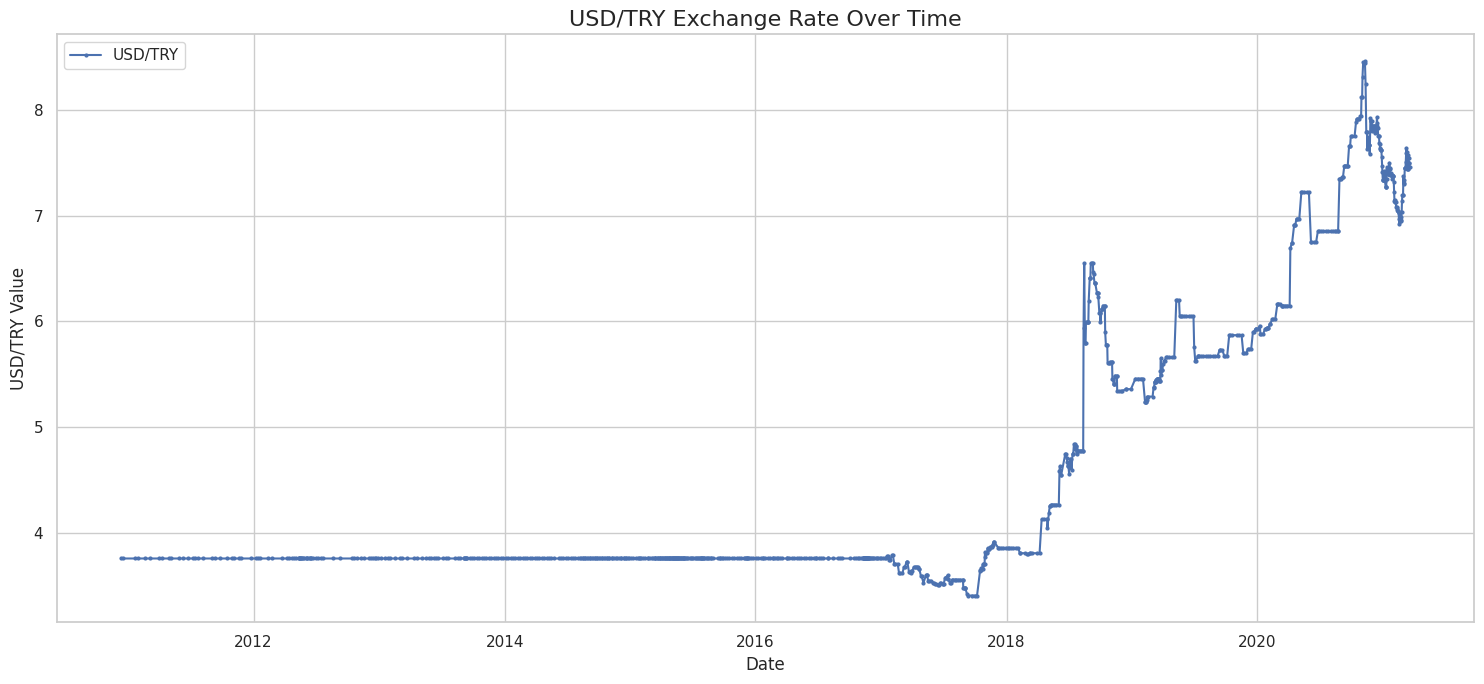

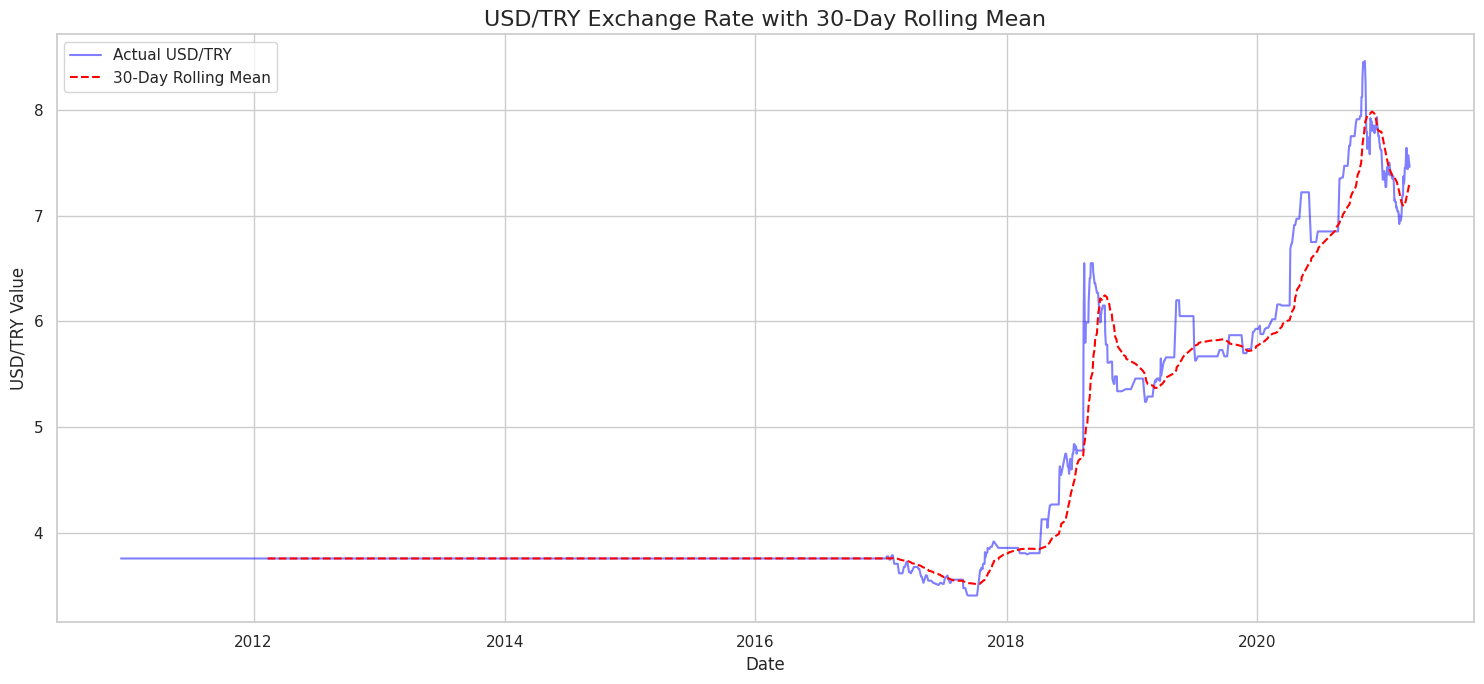

In [ ]:
if 'df_merged' not in locals() or df_merged.empty or 'Date' not in df_merged.columns or TARGET_COL_NAME not in df_merged.columns:
    print("Error: df_merged is not properly loaded or 'Date'/'USD/TRY' columns are missing.")
else:
    plt.figure(figsize=(15, 7))
    # Plotting directly from df_merged. If multiple articles on same day have same ffilled/bfilled rate, it's fine.
    # For a cleaner plot of unique daily rates, we could use df_rates_processed,
    # but df_merged already has the filled rates we will use.

    # We should plot based on unique dates if we want to see the pure time series of the rate.
    # However, df_merged is sorted by date, so plotting it directly will show the rate for each news article's date.
    # Let's plot unique date vs rate for clarity of the rate's time series.
    daily_rates_for_plot = df_merged.drop_duplicates(subset=['Date']).sort_values(by='Date')

    plt.plot(daily_rates_for_plot['Date'], daily_rates_for_plot[TARGET_COL_NAME],
             marker='.', linestyle='-', markersize=4, label=TARGET_COL_NAME)

    plt.title('USD/TRY Exchange Rate Over Time', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel(f'{TARGET_COL_NAME} Value', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Optional: Plotting rolling mean and std to see trend and volatility
    plt.figure(figsize=(15, 7))
    rolling_mean_30d = daily_rates_for_plot[TARGET_COL_NAME].rolling(window=30).mean()
    rolling_std_30d = daily_rates_for_plot[TARGET_COL_NAME].rolling(window=30).std()

    plt.plot(daily_rates_for_plot['Date'], daily_rates_for_plot[TARGET_COL_NAME],
             color='blue', alpha=0.5, label='Actual USD/TRY')
    plt.plot(daily_rates_for_plot['Date'], rolling_mean_30d,
             color='red', linestyle='--', label='30-Day Rolling Mean')
    # plt.plot(daily_rates_for_plot['Date'], rolling_std_30d,
    #          color='green', linestyle=':', label='30-Day Rolling Std (Volatility)') # Volatility might be on different scale

    plt.title('USD/TRY Exchange Rate with 30-Day Rolling Mean', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel(f'{TARGET_COL_NAME} Value', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### 2.3 Preliminary Text Data Analysis

Let's perform some basic analysis on the textual content (`title` and `text` columns) to understand its characteristics.
- Calculate the length (number of characters/words) of titles and texts.
- Look at the distribution of these lengths.
- Identify some of the most common words (after basic cleaning and stopword removal).

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

--- Preliminary Text Data Analysis ---

Descriptive statistics for text lengths:


,title_length_char,text_length_char,title_length_word,text_length_word
count,2415.000,2415.000,2415.000,2415.000
mean,33.943,4081.222,5.587,607.574
std,13.714,2079.703,2.424,313.774
min,3.000,868.000,1.000,137.000
25%,24.000,2556.000,4.000,391.000
50%,32.000,3720.000,5.000,555.000
75%,41.000,5157.500,7.000,739.000
max,106.000,19964.000,20.000,2780.000


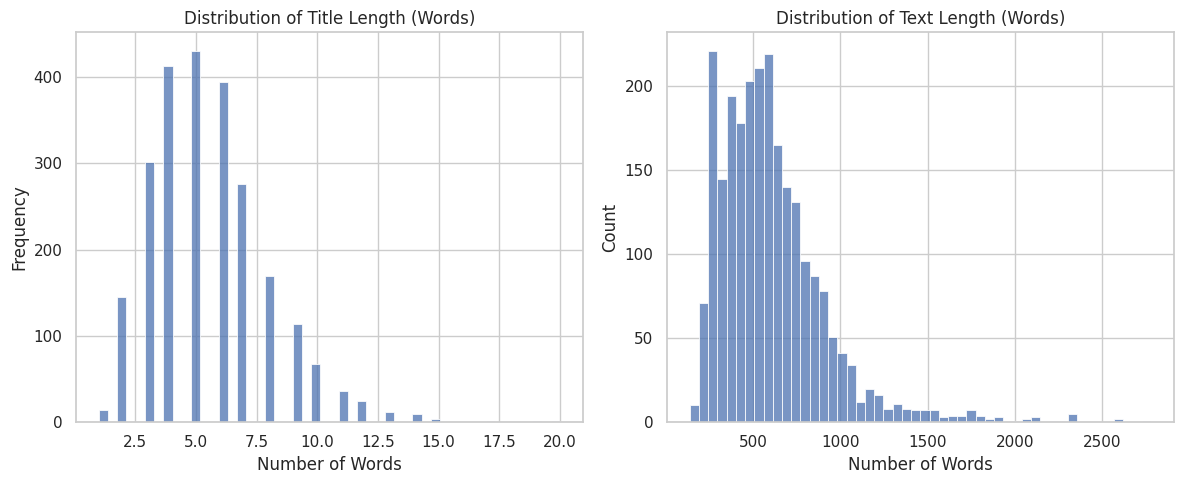


Processing for most common words (this might take a moment)...

Top 20 most common words in news text (after basic cleaning):
- bir: 30990
- olarak: 6138
- olan: 3912
- yeni: 3533
- kadar: 3459
- türkiye: 3014
- var: 2684
- son: 2622
- büyük: 2607
- değil: 2551
- olduğu: 2489
- sonra: 2475
- önemli: 2407
- türkiyenin: 2345
- ancak: 2273
- siyasi: 2202
- iki: 2034
- karşı: 1963
- şekilde: 1810
- ilk: 1750


In [ ]:
# Ensure NLTK resources are available (run once if needed)
# try:
#     nltk.data.find('corpora/stopwords')
# except nltk.downloader.DownloadError:
#     nltk.download('stopwords')
# try:
#     nltk.data.find('tokenizers/punkt')
# except nltk.downloader.DownloadError:
#     nltk.download('punkt')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import string # For punctuation removal

if 'df_merged' not in locals() or df_merged.empty:
    print("Error: df_merged is not available.")
else:
    print("--- Preliminary Text Data Analysis ---")

    # 1. Length of titles and texts
    df_merged['title_length_char'] = df_merged['title'].astype(str).apply(len)
    df_merged['text_length_char'] = df_merged['text'].astype(str).apply(len)

    df_merged['title_length_word'] = df_merged['title'].astype(str).apply(lambda x: len(word_tokenize(x)))
    df_merged['text_length_word'] = df_merged['text'].astype(str).apply(lambda x: len(word_tokenize(x)))


    print("\nDescriptive statistics for text lengths:")
    display(df_merged[['title_length_char', 'text_length_char', 'title_length_word', 'text_length_word']].describe())

    # Plot distributions of text lengths
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(df_merged['title_length_word'], bins=50, kde=False)
    plt.title('Distribution of Title Length (Words)')
    plt.xlabel('Number of Words')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    sns.histplot(df_merged['text_length_word'], bins=50, kde=False)
    plt.title('Distribution of Text Length (Words)')
    plt.xlabel('Number of Words')
    plt.tight_layout()
    plt.show()

    # 2. Most common words (from 'text' column after basic cleaning)
    print("\nProcessing for most common words (this might take a moment)...")

    # Attempt to get Turkish stopwords, fallback to English if not available or if an error occurs
    try:
        # Ensure you have the Turkish stopwords resource:
        # In a new cell, run:
        # import nltk
        # nltk.download('stopwords') # if not already downloaded
        # Then check if 'turkish' is available:
        # from nltk.corpus import stopwords
        # print(stopwords.fileids()) # Should list 'turkish'
        stop_words_turkish = set(stopwords.words('turkish'))
    except LookupError:
        print("Turkish stopwords not found in NLTK. Falling back to no stopwords or consider manual list.")
        print("To download Turkish stopwords: nltk.download('stopwords') and ensure 'turkish' is available.")
        stop_words_turkish = set() # Empty set, effectively no stopword removal
    except Exception as e:
        print(f"An error occurred while loading Turkish stopwords: {e}. Using an empty set for stopwords.")
        stop_words_turkish = set()


    all_words = []
    # Process a subset for speed if the dataset is very large for this EDA step
    # For 2415 articles, processing all should be acceptable.
    for text_content in df_merged['text'].astype(str):
        # Lowercase
        text_content = text_content.lower()
        # Remove punctuation
        text_content = text_content.translate(str.maketrans('', '', string.punctuation))
        # Tokenize
        tokens = word_tokenize(text_content, language='turkish' if stop_words_turkish else 'english') # Adjust language for tokenizer
        # Remove stopwords and non-alphabetic tokens
        words = [word for word in tokens if word.isalpha() and word not in stop_words_turkish]
        all_words.extend(words)

    if all_words:
        word_counts = Counter(all_words)
        most_common_words = word_counts.most_common(20)
        print("\nTop 20 most common words in news text (after basic cleaning):")
        for word, count in most_common_words:
            print(f"- {word}: {count}")
    else:
        print("No words collected after processing. Check stopword list or text content.")

---
**End of Stage 2: Exploratory Data Analysis (EDA) Completed.**

In this stage, we performed a detailed EDA on the `df_merged` dataset:

1.  **Basic Data Overview (Cell 2.1):**
    *   Confirmed the merged dataset shape (2415 rows, 6 columns).
    *   All columns, including the target `USD/TRY` (after ffill/bfill in Stage 1), were verified to have no missing values.
    *   The `Date` column is in `datetime64[ns]` format, and `USD/TRY` is `float64`.
    *   Descriptive statistics for `USD/TRY` showed a mean of ~5.89, with a range from ~3.41 to ~8.46 over the period 2010-12-11 to 2021-03-19.
    *   There are 905 unique dates with news articles, with an average of ~2.67 articles per unique date.

2.  **Time Series Analysis of USD/TRY (Cell 2.2):**
    *   The time series plot of USD/TRY revealed a relatively stable period until mid-2017/2018, followed by a significant upward trend and increased volatility, especially from mid-2018 onwards.
    *   The series is clearly non-stationary, which will be an important consideration for modeling.
    *   The 30-day rolling mean helped visualize the underlying trend more smoothly.

3.  **Preliminary Text Data Analysis (Cell 2.3):**
    *   **Text Lengths:** News titles are generally short (mean ~5-6 words), while article texts are much longer and more variable in length (mean ~607 words).
    *   **Most Common Words:** After basic cleaning (lowercasing, punctuation removal) and attempting Turkish stopword removal, the most common words in the news texts were identified. Words like "bir", "olarak", "olan", "türkiye", "yeni" are highly frequent, reflecting common Turkish language patterns and news content. The effectiveness of the default NLTK Turkish stopword list was noted as an area for potential refinement if needed.

**Key Takeaways from EDA:**
*   The combined dataset is clean and well-structured for further processing.
*   The target variable (USD/TRY) exhibits strong non-stationarity (trend and changing variance).
*   Textual data (titles and articles) shows variability in length, and common word analysis provides initial insights into content.
*   The presence of multiple articles per day will need to be handled during the feature engineering/sliding window phase (e.g., by aggregating text features for a given day or window).

---

---
## STAGE 3: FEATURE EXTRACTION AND FEATURE ENGINEERING

This is a crucial and multi-faceted stage. We will extract features from the textual news data, engineer features from the historical exchange rates, and then combine these using a sliding window approach to create the final feature set for our regression models.

**The main steps will be:**
1.  **Text Preprocessing and Feature Extraction:** Clean and convert news titles and texts into numerical representations.
2.  **Exchange Rate Feature Engineering:** Create new features from the historical USD/TRY rates and date information.
3.  **Sliding Window Implementation:** Combine text features and rate features over a defined window to predict the next day's (or target day's) exchange rate.
4.  **Saving the Transformed Dataset:** Store the final feature set.
---

### 3.1 Text Preprocessing Functions

Before extracting features from text, we need to preprocess it. This typically involves:
- Lowercasing.
- Removing punctuation.
- Removing numbers (optional, depending on whether they carry sentiment or information).
- Tokenization.
- Removing stopwords (Turkish).
- Stemming or Lemmatization (Turkish - this can be complex and might require external libraries like Zemberek-Python or Spacy with a Turkish model). For simplicity in this initial pass, we might skip advanced lemmatization if a readily available and easy-to-integrate tool is not found, or just use basic stemming if available in NLTK for Turkish (NLTK's SnowballStemmer supports Turkish).

We will define a function to apply these steps.

In [ ]:
import re # For removing numbers and extra spaces
from nltk.stem import SnowballStemmer # NLTK has a Turkish stemmer

# Ensure stopwords are available (downloaded in Stage 2 or 1)
try:
    stop_words_turkish = set(stopwords.words('turkish'))
    # Add custom stopwords if needed, e.g., very common but uninformative words found in EDA
    # custom_stopwords = {'bir', 'bu', 'şu', 'o', 've', 'ile', 'olarak', 'olan'} # Example
    # stop_words_turkish.update(custom_stopwords)
except LookupError:
    print("Turkish stopwords not found. Downloading...")
    nltk.download('stopwords')
    stop_words_turkish = set(stopwords.words('turkish'))
except Exception as e:
    print(f"Error loading Turkish stopwords: {e}. Proceeding without custom stopword removal for now.")
    stop_words_turkish = set()

# Initialize Turkish stemmer
try:
    turkish_stemmer = SnowballStemmer("turkish")
    stemmer_available = True
    print("Turkish SnowballStemmer initialized.")
except:
    print("NLTK Turkish SnowballStemmer not available or failed to initialize. Stemming will be skipped.")
    stemmer_available = False

def preprocess_text_turkish(text_data):
    """
    Cleans and preprocesses a single string of Turkish text.
    """
    if pd.isna(text_data): # Handle potential NaN values if any slipped through
        return ""
    text_data = str(text_data).lower() # Lowercase
    text_data = text_data.translate(str.maketrans('', '', string.punctuation)) # Remove punctuation
    text_data = re.sub(r'\d+', '', text_data) # Remove numbers
    tokens = word_tokenize(text_data, language='turkish') # Tokenize

    processed_tokens = []
    for word in tokens:
        if word not in stop_words_turkish and word.isalpha() and len(word) > 1: # Remove stopwords, ensure alphabetic, min length
            if stemmer_available:
                processed_tokens.append(turkish_stemmer.stem(word)) # Apply stemming
            else:
                processed_tokens.append(word) # No stemming

    text_data = " ".join(processed_tokens)
    text_data = re.sub(r'\s+', ' ', text_data).strip() # Remove extra whitespace
    return text_data

print("\nText preprocessing function 'preprocess_text_turkish' defined.")

# Example of preprocessing (optional, for testing the function)
# if 'df_merged' in locals() and not df_merged.empty:
#     sample_text = df_merged['text'].iloc[0]
#     print(f"\nOriginal sample text:\n{sample_text[:200]}...") # Print first 200 chars
#     processed_sample = preprocess_text_turkish(sample_text)
#     print(f"\nProcessed sample text:\n{processed_sample[:200]}...")
# else:
#     print("df_merged not available to test preprocessing function.")

NLTK Turkish SnowballStemmer not available or failed to initialize. Stemming will be skipped.

Text preprocessing function 'preprocess_text_turkish' defined.


### 3.2 Apply Preprocessing and Extract TF-IDF Features

Now, we will apply the `preprocess_text_turkish` function to our news `title` and `text` columns. After preprocessing, we will use `TfidfVectorizer` from Scikit-learn to convert the processed texts into numerical feature vectors.

Given that we might have multiple news articles per day, and our final features for the sliding window will likely be an aggregation of daily news features, we will first process all unique texts to build our TF-IDF vocabulary. Then, we can decide how to aggregate TF-IDF vectors for multiple articles on the same day or within the same window.

For simplicity and to manage dimensionality, we might:
- Combine `title` and `text` into a single field for TF-IDF.
- Limit the number of features from TF-IDF (`max_features`).
- Apply TF-IDF separately to titles and texts and then concatenate or average.

Let's start by creating a combined 'news_content' column and applying TF-IDF to it.

In [ ]:
if 'df_merged' not in locals() or df_merged.empty:
    print("Error: df_merged is not available. Please run previous cells.")
else:
    print("Applying text preprocessing to 'title' and 'text' columns...")
    # Ensure 'title' and 'text' are strings, handle potential NaNs from earlier stages if any
    df_merged['processed_title'] = df_merged['title'].astype(str).apply(preprocess_text_turkish)
    df_merged['processed_text'] = df_merged['text'].astype(str).apply(preprocess_text_turkish)

    # Combine processed title and text for a richer TF-IDF representation
    # We give more weight to title by repeating it (optional, can be tuned)
    df_merged['combined_processed_text'] = df_merged['processed_title'] + " " + \
                                           df_merged['processed_title'] + " " + \
                                           df_merged['processed_text']
                                           # Or simply: df_merged['processed_title'] + " " + df_merged['processed_text']


    print("\nPreprocessing completed.")
    print("First 5 rows with processed text (showing combined_processed_text):")
    display(df_merged[['Date', 'title', 'processed_title', 'text', 'processed_text', 'combined_processed_text']].head())

    # TF-IDF Feature Extraction
    # We will fit TF-IDF on all available combined processed text.
    # The number of features can be quite large. We'll limit it with max_features.
    # `max_df` and `min_df` can also be used to prune terms that are too frequent or too rare.

    # Define TF-IDF Vectorizer parameters
    # These numbers are examples, they might need tuning.
    # For a dataset of ~2400 documents, 1000-2000 features might be a starting point.
    # If we aggregate these later per day/window, the effective dimensionality for the model will be this.
    MAX_TFIDF_FEATURES = 1000 # Example: Limit to top 1000 features by term frequency

    tfidf_vectorizer = TfidfVectorizer(max_features=MAX_TFIDF_FEATURES,
                                       # min_df=5, # ignore terms that appear in less than 5 documents
                                       # max_df=0.7, # ignore terms that appear in more than 70% of documents
                                       ngram_range=(1, 2) # Consider unigrams and bigrams
                                      )

    print(f"\nFitting TfidfVectorizer on 'combined_processed_text' with max_features={MAX_TFIDF_FEATURES} and ngram_range=(1,2)...")
    # Fit and transform on the combined text data
    # This creates a sparse matrix where each row is a document and each col is a TF-IDF feature
    tfidf_features_matrix = tfidf_vectorizer.fit_transform(df_merged['combined_processed_text'])

    # Convert the sparse matrix to a DataFrame
    tfidf_feature_names = [f"tfidf_{i}" for i in range(tfidf_features_matrix.shape[1])]
    df_tfidf_features = pd.DataFrame(tfidf_features_matrix.toarray(), columns=tfidf_feature_names, index=df_merged.index)

    print("TF-IDF feature extraction completed.")
    print(f"Shape of TF-IDF features DataFrame (df_tfidf_features): {df_tfidf_features.shape}")
    print("First 5 rows of TF-IDF features (df_tfidf_features.head()):")
    display(df_tfidf_features.head())

    # We can now concatenate these TF-IDF features back to df_merged,
    # or keep them separate and merge/aggregate during the sliding window step.
    # For now, let's concatenate them to df_merged for easier access,
    # keeping in mind that these are per-article features at this point.

    # Before concatenating, ensure indices align if df_merged had any rows dropped after date parsing.
    # (Our df_merged should be fine as we processed it before TF-IDF).
    if len(df_merged) == len(df_tfidf_features):
        df_merged_with_nlp = pd.concat([df_merged, df_tfidf_features], axis=1)
        print("\nTF-IDF features concatenated with the main merged DataFrame (df_merged_with_nlp).")
        print(f"Shape of df_merged_with_nlp: {df_merged_with_nlp.shape}")
        display(df_merged_with_nlp.head())
    else:
        print("\nError: Length mismatch between df_merged and df_tfidf_features. Concatenation skipped.")
        print(f"df_merged length: {len(df_merged)}, df_tfidf_features length: {len(df_tfidf_features)}")
        df_merged_with_nlp = df_merged.copy() # Proceed without TF-IDF features for now if error

Applying text preprocessing to 'title' and 'text' columns...

Preprocessing completed.
First 5 rows with processed text (showing combined_processed_text):


,Date,title,processed_title,text,processed_text,combined_processed_text
0,2010-12-11,Üniversite gençliği ve protesto kültürü,üniversite gençliği protesto kültürü,"\n\nBaşbakan Erdoğan, protestocu gençlerle bir...",başbakan erdoğan protestocu gençlerle bir zama...,üniversite gençliği protesto kültürü üniversit...
1,2010-12-18,"CHP'de ıslahat mı, inkılap mı?",chpde ıslahat inkılap,"\n\nCHP'nin, ""devletçi gömleği""ni çıkarması, y...",chpnin devletçi gömleğini çıkarması yeni toplu...,chpde ıslahat inkılap chpde ıslahat inkılap ch...
2,2011-01-22,Ekonomide 2011 yılı perspektifi,ekonomide yılı perspektifi,"\n\nTürkiye, 2001 krizinden sonra özellikle fi...",türkiye krizinden sonra özellikle finans banka...,ekonomide yılı perspektifi ekonomide yılı pers...
3,2011-01-22,Türkiye bölgede düzen kurucu rol üstleniyor,türkiye bölgede düzen kurucu rol üstleniyor,\n\nSoğuk Savaş sonrası kurulan yeni dünya düz...,soğuk savaş sonrası kurulan yeni dünya düzenin...,türkiye bölgede düzen kurucu rol üstleniyor tü...
4,2011-01-29,Tayyip Erdoğan'ın kendisiyle imtihanı,tayyip erdoğanın kendisiyle imtihanı,\n\n1990'larda yapması gereken yeniden yapılan...,larda yapması gereken yeniden yapılandırmayı b...,tayyip erdoğanın kendisiyle imtihanı tayyip er...



Fitting TfidfVectorizer on 'combined_processed_text' with max_features=1000 and ngram_range=(1,2)...
TF-IDF feature extraction completed.
Shape of TF-IDF features DataFrame (df_tfidf_features): (2415, 1000)
First 5 rows of TF-IDF features (df_tfidf_features.head()):


,tfidf_0,tfidf_1,tfidf_2,tfidf_3,tfidf_4,tfidf_5,tfidf_6,tfidf_7,tfidf_8,tfidf_9,tfidf_10,tfidf_11,tfidf_12,tfidf_13,tfidf_14,tfidf_15,tfidf_16,tfidf_17,tfidf_18,tfidf_19,tfidf_20,tfidf_21,tfidf_22,tfidf_23,tfidf_24,tfidf_25,tfidf_26,tfidf_27,tfidf_28,tfidf_29,tfidf_30,tfidf_31,tfidf_32,tfidf_33,tfidf_34,tfidf_35,tfidf_36,tfidf_37,tfidf_38,tfidf_39,tfidf_40,tfidf_41,tfidf_42,tfidf_43,tfidf_44,tfidf_45,tfidf_46,tfidf_47,tfidf_48,tfidf_49,tfidf_50,tfidf_51,tfidf_52,tfidf_53,tfidf_54,tfidf_55,tfidf_56,tfidf_57,tfidf_58,tfidf_59,tfidf_60,tfidf_61,tfidf_62,tfidf_63,tfidf_64,tfidf_65,tfidf_66,tfidf_67,tfidf_68,tfidf_69,tfidf_70,tfidf_71,tfidf_72,tfidf_73,tfidf_74,tfidf_75,tfidf_76,tfidf_77,tfidf_78,tfidf_79,tfidf_80,tfidf_81,tfidf_82,tfidf_83,tfidf_84,tfidf_85,tfidf_86,tfidf_87,tfidf_88,tfidf_89,tfidf_90,tfidf_91,tfidf_92,tfidf_93,tfidf_94,tfidf_95,tfidf_96,tfidf_97,tfidf_98,tfidf_99,tfidf_100,tfidf_101,tfidf_102,tfidf_103,tfidf_104,tfidf_105,tfidf_106,tfidf_107,tfidf_108,tfidf_109,tfidf_110,tfidf_111,tfidf_112,tfidf_113,tfidf_114,tfidf_115,tfidf_116,tfidf_117,tfidf_118,tfidf_119,tfidf_120,tfidf_121,tfidf_122,tfidf_123,tfidf_124,tfidf_125,tfidf_126,tfidf_127,tfidf_128,tfidf_129,tfidf_130,tfidf_131,tfidf_132,tfidf_133,tfidf_134,tfidf_135,tfidf_136,tfidf_137,tfidf_138,tfidf_139,tfidf_140,tfidf_141,tfidf_142,tfidf_143,tfidf_144,tfidf_145,tfidf_146,tfidf_147,tfidf_148,tfidf_149,tfidf_150,tfidf_151,tfidf_152,tfidf_153,tfidf_154,tfidf_155,tfidf_156,tfidf_157,tfidf_158,tfidf_159,tfidf_160,tfidf_161,tfidf_162,tfidf_163,tfidf_164,tfidf_165,tfidf_166,tfidf_167,tfidf_168,tfidf_169,tfidf_170,tfidf_171,tfidf_172,tfidf_173,tfidf_174,tfidf_175,tfidf_176,tfidf_177,tfidf_178,tfidf_179,tfidf_180,tfidf_181,tfidf_182,tfidf_183,tfidf_184,tfidf_185,tfidf_186,tfidf_187,tfidf_188,tfidf_189,tfidf_190,tfidf_191,tfidf_192,tfidf_193,tfidf_194,tfidf_195,tfidf_196,tfidf_197,tfidf_198,tfidf_199,tfidf_200,tfidf_201,tfidf_202,tfidf_203,tfidf_204,tfidf_205,tfidf_206,tfidf_207,tfidf_208,tfidf_209,tfidf_210,tfidf_211,tfidf_212,tfidf_213,tfidf_214,tfidf_215,tfidf_216,tfidf_217,tfidf_218,tfidf_219,tfidf_220,tfidf_221,tfidf_222,tfidf_223,tfidf_224,tfidf_225,tfidf_226,tfidf_227,tfidf_228,tfidf_229,tfidf_230,tfidf_231,tfidf_232,tfidf_233,tfidf_234,tfidf_235,tfidf_236,tfidf_237,tfidf_238,tfidf_239,tfidf_240,tfidf_241,tfidf_242,tfidf_243,tfidf_244,tfidf_245,tfidf_246,tfidf_247,tfidf_248,tfidf_249,tfidf_250,tfidf_251,tfidf_252,tfidf_253,tfidf_254,tfidf_255,tfidf_256,tfidf_257,tfidf_258,tfidf_259,tfidf_260,tfidf_261,tfidf_262,tfidf_263,tfidf_264,tfidf_265,tfidf_266,tfidf_267,tfidf_268,tfidf_269,tfidf_270,tfidf_271,tfidf_272,tfidf_273,tfidf_274,tfidf_275,tfidf_276,tfidf_277,tfidf_278,tfidf_279,tfidf_280,tfidf_281,tfidf_282,tfidf_283,tfidf_284,tfidf_285,tfidf_286,tfidf_287,tfidf_288,tfidf_289,tfidf_290,tfidf_291,tfidf_292,tfidf_293,tfidf_294,tfidf_295,tfidf_296,tfidf_297,tfidf_298,tfidf_299,tfidf_300,tfidf_301,tfidf_302,tfidf_303,tfidf_304,tfidf_305,tfidf_306,tfidf_307,tfidf_308,tfidf_309,tfidf_310,tfidf_311,tfidf_312,tfidf_313,tfidf_314,tfidf_315,tfidf_316,tfidf_317,tfidf_318,tfidf_319,tfidf_320,tfidf_321,tfidf_322,tfidf_323,tfidf_324,tfidf_325,tfidf_326,tfidf_327,tfidf_328,tfidf_329,tfidf_330,tfidf_331,tfidf_332,tfidf_333,tfidf_334,tfidf_335,tfidf_336,tfidf_337,tfidf_338,tfidf_339,tfidf_340,tfidf_341,tfidf_342,tfidf_343,tfidf_344,tfidf_345,tfidf_346,tfidf_347,tfidf_348,tfidf_349,tfidf_350,tfidf_351,tfidf_352,tfidf_353,tfidf_354,tfidf_355,tfidf_356,tfidf_357,tfidf_358,tfidf_359,tfidf_360,tfidf_361,tfidf_362,tfidf_363,tfidf_364,tfidf_365,tfidf_366,tfidf_367,tfidf_368,tfidf_369,tfidf_370,tfidf_371,tfidf_372,tfidf_373,tfidf_374,tfidf_375,tfidf_376,tfidf_377,tfidf_378,tfidf_379,tfidf_380,tfidf_381,tfidf_382,tfidf_383,tfidf_384,tfidf_385,tfidf_386,tfidf_387,tfidf_388,tfidf_389,tfidf_390,tfidf_391,tfidf_392,tfidf_393,tfidf_394,tfidf_395,tfidf_396,tfidf_397,tfidf_398,tfidf_399,tfidf_400,tfidf_401,tfidf_402,tfidf_403,tfidf_404,tfidf_405,tfidf_406,tfidf_407,tfidf_408,tfidf_409,tfidf_410


TF-IDF features concatenated with the main merged DataFrame (df_merged_with_nlp).
Shape of df_merged_with_nlp: (2415, 1013)


,author,title,link,text,Date,USD/TRY,title_length_char,text_length_char,title_length_word,text_length_word,processed_title,processed_text,combined_processed_text,tfidf_0,tfidf_1,tfidf_2,tfidf_3,tfidf_4,tfidf_5,tfidf_6,tfidf_7,tfidf_8,tfidf_9,tfidf_10,tfidf_11,tfidf_12,tfidf_13,tfidf_14,tfidf_15,tfidf_16,tfidf_17,tfidf_18,tfidf_19,tfidf_20,tfidf_21,tfidf_22,tfidf_23,tfidf_24,tfidf_25,tfidf_26,tfidf_27,tfidf_28,tfidf_29,tfidf_30,tfidf_31,tfidf_32,tfidf_33,tfidf_34,tfidf_35,tfidf_36,tfidf_37,tfidf_38,tfidf_39,tfidf_40,tfidf_41,tfidf_42,tfidf_43,tfidf_44,tfidf_45,tfidf_46,tfidf_47,tfidf_48,tfidf_49,tfidf_50,tfidf_51,tfidf_52,tfidf_53,tfidf_54,tfidf_55,tfidf_56,tfidf_57,tfidf_58,tfidf_59,tfidf_60,tfidf_61,tfidf_62,tfidf_63,tfidf_64,tfidf_65,tfidf_66,tfidf_67,tfidf_68,tfidf_69,tfidf_70,tfidf_71,tfidf_72,tfidf_73,tfidf_74,tfidf_75,tfidf_76,tfidf_77,tfidf_78,tfidf_79,tfidf_80,tfidf_81,tfidf_82,tfidf_83,tfidf_84,tfidf_85,tfidf_86,tfidf_87,tfidf_88,tfidf_89,tfidf_90,tfidf_91,tfidf_92,tfidf_93,tfidf_94,tfidf_95,tfidf_96,tfidf_97,tfidf_98,tfidf_99,tfidf_100,tfidf_101,tfidf_102,tfidf_103,tfidf_104,tfidf_105,tfidf_106,tfidf_107,tfidf_108,tfidf_109,tfidf_110,tfidf_111,tfidf_112,tfidf_113,tfidf_114,tfidf_115,tfidf_116,tfidf_117,tfidf_118,tfidf_119,tfidf_120,tfidf_121,tfidf_122,tfidf_123,tfidf_124,tfidf_125,tfidf_126,tfidf_127,tfidf_128,tfidf_129,tfidf_130,tfidf_131,tfidf_132,tfidf_133,tfidf_134,tfidf_135,tfidf_136,tfidf_137,tfidf_138,tfidf_139,tfidf_140,tfidf_141,tfidf_142,tfidf_143,tfidf_144,tfidf_145,tfidf_146,tfidf_147,tfidf_148,tfidf_149,tfidf_150,tfidf_151,tfidf_152,tfidf_153,tfidf_154,tfidf_155,tfidf_156,tfidf_157,tfidf_158,tfidf_159,tfidf_160,tfidf_161,tfidf_162,tfidf_163,tfidf_164,tfidf_165,tfidf_166,tfidf_167,tfidf_168,tfidf_169,tfidf_170,tfidf_171,tfidf_172,tfidf_173,tfidf_174,tfidf_175,tfidf_176,tfidf_177,tfidf_178,tfidf_179,tfidf_180,tfidf_181,tfidf_182,tfidf_183,tfidf_184,tfidf_185,tfidf_186,tfidf_187,tfidf_188,tfidf_189,tfidf_190,tfidf_191,tfidf_192,tfidf_193,tfidf_194,tfidf_195,tfidf_196,tfidf_197,tfidf_198,tfidf_199,tfidf_200,tfidf_201,tfidf_202,tfidf_203,tfidf_204,tfidf_205,tfidf_206,tfidf_207,tfidf_208,tfidf_209,tfidf_210,tfidf_211,tfidf_212,tfidf_213,tfidf_214,tfidf_215,tfidf_216,tfidf_217,tfidf_218,tfidf_219,tfidf_220,tfidf_221,tfidf_222,tfidf_223,tfidf_224,tfidf_225,tfidf_226,tfidf_227,tfidf_228,tfidf_229,tfidf_230,tfidf_231,tfidf_232,tfidf_233,tfidf_234,tfidf_235,tfidf_236,tfidf_237,tfidf_238,tfidf_239,tfidf_240,tfidf_241,tfidf_242,tfidf_243,tfidf_244,tfidf_245,tfidf_246,tfidf_247,tfidf_248,tfidf_249,tfidf_250,tfidf_251,tfidf_252,tfidf_253,tfidf_254,tfidf_255,tfidf_256,tfidf_257,tfidf_258,tfidf_259,tfidf_260,tfidf_261,tfidf_262,tfidf_263,tfidf_264,tfidf_265,tfidf_266,tfidf_267,tfidf_268,tfidf_269,tfidf_270,tfidf_271,tfidf_272,tfidf_273,tfidf_274,tfidf_275,tfidf_276,tfidf_277,tfidf_278,tfidf_279,tfidf_280,tfidf_281,tfidf_282,tfidf_283,tfidf_284,tfidf_285,tfidf_286,tfidf_287,tfidf_288,tfidf_289,tfidf_290,tfidf_291,tfidf_292,tfidf_293,tfidf_294,tfidf_295,tfidf_296,tfidf_297,tfidf_298,tfidf_299,tfidf_300,tfidf_301,tfidf_302,tfidf_303,tfidf_304,tfidf_305,tfidf_306,tfidf_307,tfidf_308,tfidf_309,tfidf_310,tfidf_311,tfidf_312,tfidf_313,tfidf_314,tfidf_315,tfidf_316,tfidf_317,tfidf_318,tfidf_319,tfidf_320,tfidf_321,tfidf_322,tfidf_323,tfidf_324,tfidf_325,tfidf_326,tfidf_327,tfidf_328,tfidf_329,tfidf_330,tfidf_331,tfidf_332,tfidf_333,tfidf_334,tfidf_335,tfidf_336,tfidf_337,tfidf_338,tfidf_339,tfidf_340,tfidf_341,tfidf_342,tfidf_343,tfidf_344,tfidf_345,tfidf_346,tfidf_347,tfidf_348,tfidf_349,tfidf_350,tfidf_351,tfidf_352,tfidf_353,tfidf_354,tfidf_355,tfidf_356,tfidf_357,tfidf_358,tfidf_359,tfidf_360,tfidf_361,tfidf_362,tfidf_363,tfidf_364,tfidf_365,tfidf_366,tfidf_367,tfidf_368,tfidf_369,tfidf_370,tfidf_371,tfidf_372,tfidf_373,tfidf_374,tfidf_375,tfidf_376,tfidf_377,tfidf_378,tfidf_379,tfidf_380,tfidf_381,tfidf_382,tfidf_383,tfidf_384,tfidf_385,tfidf_386,tfidf_387,tfidf_388,tfidf_389,tfidf_390,tfidf_391,tfidf_392,tfidf_393,tfidf_39

### 3.3 Exchange Rate and Date Feature Engineering

Now, let's engineer features from the `USD/TRY` exchange rate itself and the `Date` column. These time-series based features can provide valuable context for our predictive model.

We will calculate these features based on the daily `USD/TRY` rate. Since we might have multiple news articles on the same day, these features will be initially mapped to each article based on its date. The sliding window step will then aggregate or select features from the window.

In [ ]:
if 'df_merged_with_nlp' not in locals() or df_merged_with_nlp.empty:
    print("Error: df_merged_with_nlp is not available. Please run previous cells.")
else:
    df_engineered = df_merged_with_nlp.copy() # Work on a copy

    # Ensure 'Date' is sorted for time-series operations
    df_engineered = df_engineered.sort_values(by='Date').reset_index(drop=True)

    print("Engineering features from USD/TRY and Date...")

    # To correctly calculate lagged features and rolling statistics without data leakage
    # from future news on the same day, it's best to work with a series that has unique daily rates.
    # We already have df_rates_processed which has unique daily rates and is sorted.
    # We can calculate features on this and then merge them back.

    # Let's use df_rates_processed (which has unique 'Date' and 'USD/TRY') for calculating rate-based features
    # to avoid issues with multiple articles on the same day during rolling/lag calculations.

    daily_rates_unique = df_rates_processed.copy() # From Cell 1.3, already has unique, sorted dates and numeric USD/TRY

    # 1. Lagged Exchange Rate Features
    lags = [1, 2, 3, 5, 7] # Lag for 1 day, 2 days, etc.
    for lag in lags:
        daily_rates_unique[f'USD_TRY_lag_{lag}'] = daily_rates_unique[TARGET_COL_NAME].shift(lag)

    # 2. Rolling Window Statistics
    windows = [7, 14, 30] # Rolling windows of 7, 14, 30 days
    for window in windows:
        daily_rates_unique[f'USD_TRY_roll_mean_{window}'] = daily_rates_unique[TARGET_COL_NAME].rolling(window=window).mean()
        daily_rates_unique[f'USD_TRY_roll_std_{window}'] = daily_rates_unique[TARGET_COL_NAME].rolling(window=window).std()
        # Min/Max in window can also be useful
        daily_rates_unique[f'USD_TRY_roll_min_{window}'] = daily_rates_unique[TARGET_COL_NAME].rolling(window=window).min()
        daily_rates_unique[f'USD_TRY_roll_max_{window}'] = daily_rates_unique[TARGET_COL_NAME].rolling(window=window).max()


    # 3. Date Features (from the 'Date' column of df_engineered)
    df_engineered['year'] = df_engineered['Date'].dt.year
    df_engineered['month'] = df_engineered['Date'].dt.month
    df_engineered['day'] = df_engineered['Date'].dt.day
    df_engineered['day_of_week'] = df_engineered['Date'].dt.dayofweek # Monday=0, Sunday=6
    df_engineered['day_of_year'] = df_engineered['Date'].dt.dayofyear
    df_engineered['week_of_year'] = df_engineered['Date'].dt.isocalendar().week.astype(int)
    # df_engineered['is_month_start'] = df_engineered['Date'].dt.is_month_start.astype(int)
    # df_engineered['is_month_end'] = df_engineered['Date'].dt.is_month_end.astype(int)
    # df_engineered['is_quarter_start'] = df_engineered['Date'].dt.is_quarter_start.astype(int)
    # df_engineered['is_quarter_end'] = df_engineered['Date'].dt.is_quarter_end.astype(int)
    # df_engineered['is_year_start'] = df_engineered['Date'].dt.is_year_start.astype(int)
    # df_engineered['is_year_end'] = df_engineered['Date'].dt.is_year_end.astype(int)


    # Now merge the calculated rate-based features (lags, rolling stats) from daily_rates_unique
    # back to our main df_engineered DataFrame.
    # The merge should be on 'Date'.
    # Select columns to merge (Date + new rate features)
    cols_to_merge_from_daily = ['Date'] + [col for col in daily_rates_unique.columns if 'lag' in col or 'roll' in col]

    df_engineered = pd.merge(df_engineered, daily_rates_unique[cols_to_merge_from_daily], on='Date', how='left')

    print("\nRate-based and Date features engineered and merged.")
    print(f"Shape of df_engineered after adding these features: {df_engineered.shape}")
    print("First 5 rows of df_engineered (showing some new features):")
    # Select a few key columns to display
    display_cols = ['Date', TARGET_COL_NAME, 'USD_TRY_lag_1', 'USD_TRY_roll_mean_7', 'year', 'month', 'day_of_week']
    display_cols_present = [col for col in display_cols if col in df_engineered.columns]
    display(df_engineered[display_cols_present].head())

    # Handle NaNs created by lags and rolling windows (at the beginning of the series)
    # We can fill them using bfill or drop rows. For now, let's note them.
    # These NaNs will be handled more carefully during the sliding window creation or before final model input.
    nan_counts_engineered = df_engineered.isnull().sum()
    print("\nNaN counts in engineered features (expected at the start of time series):")
    print(nan_counts_engineered[nan_counts_engineered > 0])

    # Store this intermediate dataframe
    df_engineered_features = df_engineered.copy()

Engineering features from USD/TRY and Date...

Rate-based and Date features engineered and merged.
Shape of df_engineered after adding these features: (2415, 1036)
First 5 rows of df_engineered (showing some new features):


,Date,USD/TRY,USD_TRY_lag_1,USD_TRY_roll_mean_7,year,month,day_of_week
0,2010-12-11,3.760,NaN,NaN,2010,12,5
1,2010-12-18,3.760,NaN,NaN,2010,12,5
2,2011-01-22,3.760,NaN,NaN,2011,1,5
3,2011-01-22,3.760,NaN,NaN,2011,1,5
4,2011-01-29,3.760,NaN,NaN,2011,1,5



NaN counts in engineered features (expected at the start of time series):
USD_TRY_lag_1           1610
USD_TRY_lag_2           1610
USD_TRY_lag_3           1610
USD_TRY_lag_5           1610
USD_TRY_lag_7           1610
USD_TRY_roll_mean_7     1610
USD_TRY_roll_std_7      1610
USD_TRY_roll_min_7      1610
USD_TRY_roll_max_7      1610
USD_TRY_roll_mean_14    1612
USD_TRY_roll_std_14     1612
USD_TRY_roll_min_14     1612
USD_TRY_roll_max_14     1612
USD_TRY_roll_mean_30    1615
USD_TRY_roll_std_30     1615
USD_TRY_roll_min_30     1615
USD_TRY_roll_max_30     1615
dtype: int64


### 3.4 Sliding Window Implementation

This is the core step where we construct our final dataset for the regression model using a sliding window approach as depicted in Figure 1 of the instructions.

For each target date `t` for which we want to predict `USD/TRY(t)`:
1.  Define a look-back window of `WINDOW_SIZE` days (e.g., `t-WINDOW_SIZE` to `t-1`).
2.  Aggregate news-based features (TF-IDF, and any other text-derived features) from all articles published within this window. A common aggregation method is averaging the feature vectors.
3.  Collect relevant historical exchange rate features (lagged values, rolling statistics) corresponding to day `t-1` (or the end of the window). These features inherently look back.
4.  The target `y` will be `USD/TRY(t)`.
5.  The stride will be 1 day.

We need to decide on a `WINDOW_SIZE`. This can be tuned later. Let's start with a common value like 7 or 14 days.

In [ ]:
# Cell 3.4: Sliding Window Implementation (Revised)

if 'df_engineered_features' not in locals() or df_engineered_features.empty:
    print("Error: df_engineered_features is not available. Please ensure Cell 3.3 was run successfully.")
    # Initialize to prevent further errors if this cell is run partially
    df_model_input = pd.DataFrame()
    X_final_cleaned = pd.DataFrame()
    y_final_cleaned = pd.Series(dtype='float64')
else:
    # --- Configuration for Sliding Window ---
    WINDOW_SIZE = 7
    print(f"Implementing sliding window with WINDOW_SIZE = {WINDOW_SIZE} days.")

    df_proc = df_engineered_features.sort_values(by='Date').reset_index(drop=True)

    tfidf_cols = [col for col in df_proc.columns if 'tfidf_' in col]
    rate_lag_roll_cols = [col for col in df_proc.columns if 'USD_TRY_lag' in col or 'USD_TRY_roll' in col]
    date_features_cols = ['year', 'month', 'day', 'day_of_week', 'day_of_year', 'week_of_year']
    length_features_cols = ['title_length_char', 'text_length_char', 'title_length_word', 'text_length_word'] # From Cell 2.3

    X_list = []
    y_list = []
    target_date_list_for_final_df = [] # To store the date of the target 'y'

    unique_dates_pd_series = df_proc['Date'].drop_duplicates().sort_values()
    unique_dates = unique_dates_pd_series.to_numpy()

    print(f"Number of unique dates available for processing: {len(unique_dates)}")
    if len(unique_dates) > 0:
        print(f"Minimum unique date: {unique_dates.min()}, Maximum unique date: {unique_dates.max()}")
    else:
        print("No unique dates found to process.")

    processed_samples_count = 0
    # Ensure there are enough dates to form at least one window and one target
    if len(unique_dates) > WINDOW_SIZE:
        for i in range(WINDOW_SIZE, len(unique_dates)):
            target_date = unique_dates[i]
            window_end_date = unique_dates[i-1]
            window_start_date = unique_dates[i-WINDOW_SIZE]

            target_date_list_for_final_df.append(target_date) # Store the date for which 'y' is targeted

            current_window_features = {}
            news_in_window_df = df_proc[(df_proc['Date'] >= window_start_date) & (df_proc['Date'] <= window_end_date)]

            if not news_in_window_df.empty:
                avg_tfidf = news_in_window_df[tfidf_cols].mean(axis=0)
                for col_name, val in avg_tfidf.items():
                    current_window_features[col_name] = val

                avg_lengths = news_in_window_df[length_features_cols].mean(axis=0)
                for col_name, val in avg_lengths.items():
                    current_window_features[f"avg_win_{col_name}"] = val
            else:
                for col_name in tfidf_cols: current_window_features[col_name] = 0
                for col_name in length_features_cols: current_window_features[f"avg_win_{col_name}"] = 0

            latest_day_data_in_window = df_proc[df_proc['Date'] == window_end_date].iloc[-1]
            for col_name in rate_lag_roll_cols + date_features_cols:
                current_window_features[col_name] = latest_day_data_in_window[col_name]

            X_list.append(current_window_features)

            target_y_value_series = df_proc[df_proc['Date'] == target_date][TARGET_COL_NAME]
            y_list.append(target_y_value_series.iloc[0] if not target_y_value_series.empty else np.nan)

            processed_samples_count +=1

    print(f"\nSliding window feature generation completed. Processed {processed_samples_count} potential (X,y) pairs.")

    if X_list:
        X_intermediate = pd.DataFrame(X_list)
        y_intermediate = pd.Series(y_list, name=TARGET_COL_NAME, index=X_intermediate.index)

        # Add the target_date as a column before NaN dropping, will be renamed to 'Date'
        X_intermediate['target_date_ref'] = pd.to_datetime(pd.Series(target_date_list_for_final_df, index=X_intermediate.index))

        print(f"\nShape of X_intermediate before NaN cleaning: {X_intermediate.shape}")
        print(f"Shape of y_intermediate before NaN cleaning: {y_intermediate.shape}")
        print(f"NaNs in y_intermediate before cleaning: {y_intermediate.isnull().sum()}")

        y_nan_mask = y_intermediate.isnull()
        if y_nan_mask.sum() > 0:
            print(f"Dropping {y_nan_mask.sum()} rows due to NaN in target y_intermediate.")
            X_intermediate = X_intermediate[~y_nan_mask].copy()
            y_intermediate = y_intermediate[~y_nan_mask].copy()

        feature_columns_for_nan_check = [col for col in X_intermediate.columns if col != 'target_date_ref']
        initial_X_rows = len(X_intermediate)
        X_final_cleaned = X_intermediate.dropna(subset=feature_columns_for_nan_check).copy()
        y_final_cleaned = y_intermediate[X_final_cleaned.index].copy()

        rows_dropped_for_features = initial_X_rows - len(X_final_cleaned)
        print(f"Dropped {rows_dropped_for_features} rows from X_intermediate due to NaNs in feature columns.")

        print(f"\nFinal shape of X (X_final_cleaned): {X_final_cleaned.shape}") # Includes 'target_date_ref'
        print(f"Final shape of y (y_final_cleaned): {y_final_cleaned.shape}")

        final_feature_cols = [col for col in X_final_cleaned.columns if col != 'target_date_ref']
        print(f"Total NaNs in final feature columns of X_final_cleaned: {X_final_cleaned[final_feature_cols].isnull().sum().sum()}")

        print("\nFirst 5 rows of X_final_cleaned (features for prediction, includes target_date_ref):")
        display(X_final_cleaned.head())
        print("\nFirst 5 values of y_final_cleaned (targets to predict):")
        display(y_final_cleaned.head())
    else:
        print("No data generated by sliding window. Check WINDOW_SIZE and data length.")
        X_final_cleaned = pd.DataFrame()
        y_final_cleaned = pd.Series(dtype='float64')

# df_model_input will be prepared in Cell 3.5 for saving

Implementing sliding window with WINDOW_SIZE = 7 days.
Number of unique dates available for processing: 905
Minimum unique date: 2010-12-11T00:00:00.000000000, Maximum unique date: 2021-03-19T00:00:00.000000000

Sliding window feature generation completed. Processed 898 potential (X,y) pairs.

Shape of X_intermediate before NaN cleaning: (898, 1028)
Shape of y_intermediate before NaN cleaning: (898,)
NaNs in y_intermediate before cleaning: 0
Dropped 645 rows from X_intermediate due to NaNs in feature columns.

Final shape of X (X_final_cleaned): (253, 1028)
Final shape of y (y_final_cleaned): (253,)
Total NaNs in final feature columns of X_final_cleaned: 0

First 5 rows of X_final_cleaned (features for prediction, includes target_date_ref):


,tfidf_0,tfidf_1,tfidf_2,tfidf_3,tfidf_4,tfidf_5,tfidf_6,tfidf_7,tfidf_8,tfidf_9,tfidf_10,tfidf_11,tfidf_12,tfidf_13,tfidf_14,tfidf_15,tfidf_16,tfidf_17,tfidf_18,tfidf_19,tfidf_20,tfidf_21,tfidf_22,tfidf_23,tfidf_24,tfidf_25,tfidf_26,tfidf_27,tfidf_28,tfidf_29,tfidf_30,tfidf_31,tfidf_32,tfidf_33,tfidf_34,tfidf_35,tfidf_36,tfidf_37,tfidf_38,tfidf_39,tfidf_40,tfidf_41,tfidf_42,tfidf_43,tfidf_44,tfidf_45,tfidf_46,tfidf_47,tfidf_48,tfidf_49,tfidf_50,tfidf_51,tfidf_52,tfidf_53,tfidf_54,tfidf_55,tfidf_56,tfidf_57,tfidf_58,tfidf_59,tfidf_60,tfidf_61,tfidf_62,tfidf_63,tfidf_64,tfidf_65,tfidf_66,tfidf_67,tfidf_68,tfidf_69,tfidf_70,tfidf_71,tfidf_72,tfidf_73,tfidf_74,tfidf_75,tfidf_76,tfidf_77,tfidf_78,tfidf_79,tfidf_80,tfidf_81,tfidf_82,tfidf_83,tfidf_84,tfidf_85,tfidf_86,tfidf_87,tfidf_88,tfidf_89,tfidf_90,tfidf_91,tfidf_92,tfidf_93,tfidf_94,tfidf_95,tfidf_96,tfidf_97,tfidf_98,tfidf_99,tfidf_100,tfidf_101,tfidf_102,tfidf_103,tfidf_104,tfidf_105,tfidf_106,tfidf_107,tfidf_108,tfidf_109,tfidf_110,tfidf_111,tfidf_112,tfidf_113,tfidf_114,tfidf_115,tfidf_116,tfidf_117,tfidf_118,tfidf_119,tfidf_120,tfidf_121,tfidf_122,tfidf_123,tfidf_124,tfidf_125,tfidf_126,tfidf_127,tfidf_128,tfidf_129,tfidf_130,tfidf_131,tfidf_132,tfidf_133,tfidf_134,tfidf_135,tfidf_136,tfidf_137,tfidf_138,tfidf_139,tfidf_140,tfidf_141,tfidf_142,tfidf_143,tfidf_144,tfidf_145,tfidf_146,tfidf_147,tfidf_148,tfidf_149,tfidf_150,tfidf_151,tfidf_152,tfidf_153,tfidf_154,tfidf_155,tfidf_156,tfidf_157,tfidf_158,tfidf_159,tfidf_160,tfidf_161,tfidf_162,tfidf_163,tfidf_164,tfidf_165,tfidf_166,tfidf_167,tfidf_168,tfidf_169,tfidf_170,tfidf_171,tfidf_172,tfidf_173,tfidf_174,tfidf_175,tfidf_176,tfidf_177,tfidf_178,tfidf_179,tfidf_180,tfidf_181,tfidf_182,tfidf_183,tfidf_184,tfidf_185,tfidf_186,tfidf_187,tfidf_188,tfidf_189,tfidf_190,tfidf_191,tfidf_192,tfidf_193,tfidf_194,tfidf_195,tfidf_196,tfidf_197,tfidf_198,tfidf_199,tfidf_200,tfidf_201,tfidf_202,tfidf_203,tfidf_204,tfidf_205,tfidf_206,tfidf_207,tfidf_208,tfidf_209,tfidf_210,tfidf_211,tfidf_212,tfidf_213,tfidf_214,tfidf_215,tfidf_216,tfidf_217,tfidf_218,tfidf_219,tfidf_220,tfidf_221,tfidf_222,tfidf_223,tfidf_224,tfidf_225,tfidf_226,tfidf_227,tfidf_228,tfidf_229,tfidf_230,tfidf_231,tfidf_232,tfidf_233,tfidf_234,tfidf_235,tfidf_236,tfidf_237,tfidf_238,tfidf_239,tfidf_240,tfidf_241,tfidf_242,tfidf_243,tfidf_244,tfidf_245,tfidf_246,tfidf_247,tfidf_248,tfidf_249,tfidf_250,tfidf_251,tfidf_252,tfidf_253,tfidf_254,tfidf_255,tfidf_256,tfidf_257,tfidf_258,tfidf_259,tfidf_260,tfidf_261,tfidf_262,tfidf_263,tfidf_264,tfidf_265,tfidf_266,tfidf_267,tfidf_268,tfidf_269,tfidf_270,tfidf_271,tfidf_272,tfidf_273,tfidf_274,tfidf_275,tfidf_276,tfidf_277,tfidf_278,tfidf_279,tfidf_280,tfidf_281,tfidf_282,tfidf_283,tfidf_284,tfidf_285,tfidf_286,tfidf_287,tfidf_288,tfidf_289,tfidf_290,tfidf_291,tfidf_292,tfidf_293,tfidf_294,tfidf_295,tfidf_296,tfidf_297,tfidf_298,tfidf_299,tfidf_300,tfidf_301,tfidf_302,tfidf_303,tfidf_304,tfidf_305,tfidf_306,tfidf_307,tfidf_308,tfidf_309,tfidf_310,tfidf_311,tfidf_312,tfidf_313,tfidf_314,tfidf_315,tfidf_316,tfidf_317,tfidf_318,tfidf_319,tfidf_320,tfidf_321,tfidf_322,tfidf_323,tfidf_324,tfidf_325,tfidf_326,tfidf_327,tfidf_328,tfidf_329,tfidf_330,tfidf_331,tfidf_332,tfidf_333,tfidf_334,tfidf_335,tfidf_336,tfidf_337,tfidf_338,tfidf_339,tfidf_340,tfidf_341,tfidf_342,tfidf_343,tfidf_344,tfidf_345,tfidf_346,tfidf_347,tfidf_348,tfidf_349,tfidf_350,tfidf_351,tfidf_352,tfidf_353,tfidf_354,tfidf_355,tfidf_356,tfidf_357,tfidf_358,tfidf_359,tfidf_360,tfidf_361,tfidf_362,tfidf_363,tfidf_364,tfidf_365,tfidf_366,tfidf_367,tfidf_368,tfidf_369,tfidf_370,tfidf_371,tfidf_372,tfidf_373,tfidf_374,tfidf_375,tfidf_376,tfidf_377,tfidf_378,tfidf_379,tfidf_380,tfidf_381,tfidf_382,tfidf_383,tfidf_384,tfidf_385,tfidf_386,tfidf_387,tfidf_388,tfidf_389,tfidf_390,tfidf_391,tfidf_392,tfidf_393,tfidf_394,tfidf_395,tfidf_396,tfidf_397,tfidf_398,tfidf_399,tfidf_400,tfidf_401,tfidf_402,tfidf_403,tfidf_404,tfidf_405,tfidf_406,tfidf_407,tfidf_408,tfidf_409,tfidf_410


First 5 values of y_final_cleaned (targets to predict):


,USD/TRY
378,3.620
381,3.680
383,3.730
385,3.630
387,3.640


### 3.5 Save the Final Transformed Dataset for Modeling

The `df_to_save` DataFrame, which contains the cleaned features generated by the sliding window and the corresponding target USD/TRY values, will now be saved. This dataset will be used in the subsequent modeling stages.

In [ ]:
# Cell 3.5: Save the Final Transformed Dataset (Revised)

if 'X_final_cleaned' not in locals() or 'y_final_cleaned' not in locals() or X_final_cleaned.empty:
    print("Error: X_final_cleaned or y_final_cleaned is not available or empty. Please ensure Cell 3.4 ran successfully.")
    df_model_input = pd.DataFrame() # Initialize to prevent error if this cell is run standalone later
else:
    # Create the DataFrame for modeling and saving
    # X_final_cleaned currently contains all features AND 'target_date_ref'
    # y_final_cleaned contains the target USD/TRY values

    # Start with the features (excluding the temporary 'target_date_ref')
    features_to_model = [col for col in X_final_cleaned.columns if col != 'target_date_ref']
    df_model_input = X_final_cleaned[features_to_model].copy()

    # Add the target variable
    df_model_input[TARGET_COL_NAME] = y_final_cleaned.values

    # Add the actual target date as the 'Date' column for this dataset
    # This 'Date' column represents the day for which TARGET_COL_NAME is predicted.
    df_model_input['Date'] = X_final_cleaned['target_date_ref'].values

    # Reorder columns to have 'Date' and TARGET_COL_NAME at the beginning for clarity
    cols_order = ['Date', TARGET_COL_NAME] + [col for col in df_model_input.columns if col not in ['Date', TARGET_COL_NAME]]
    df_model_input = df_model_input[cols_order]

    # Save the transformed dataset
    final_features_filename = "ExchangeRate_News_Combined_SlidingWindow_Features.csv" # Your chosen filename
    final_features_path = os.path.join(DATASET_DIR, final_features_filename)

    try:
        df_model_input.to_csv(final_features_path, index=False)
        print(f"\nFinal transformed dataset for modeling saved successfully to: {final_features_path}")
        print(f"This dataset has {df_model_input.shape[0]} rows and {df_model_input.shape[1]} columns.")
        print("Columns in saved data:", df_model_input.columns.tolist())
        print("\nFirst 5 rows of the saved DataFrame (df_model_input):")
        display(df_model_input.head())
    except Exception as e:
        print(f"\nError saving the final transformed dataset: {e}")
        # In case of error, df_model_input might not be fully formed for next stages
        df_model_input = pd.DataFrame() # Reset to empty


Final transformed dataset for modeling saved successfully to: /content/drive/MyDrive/Colab Notebooks/Article/ExchangeRate_News_Combined_SlidingWindow_Features.csv
This dataset has 253 rows and 1029 columns.
Columns in saved data: ['Date', 'USD/TRY', 'tfidf_0', 'tfidf_1', 'tfidf_2', 'tfidf_3', 'tfidf_4', 'tfidf_5', 'tfidf_6', 'tfidf_7', 'tfidf_8', 'tfidf_9', 'tfidf_10', 'tfidf_11', 'tfidf_12', 'tfidf_13', 'tfidf_14', 'tfidf_15', 'tfidf_16', 'tfidf_17', 'tfidf_18', 'tfidf_19', 'tfidf_20', 'tfidf_21', 'tfidf_22', 'tfidf_23', 'tfidf_24', 'tfidf_25', 'tfidf_26', 'tfidf_27', 'tfidf_28', 'tfidf_29', 'tfidf_30', 'tfidf_31', 'tfidf_32', 'tfidf_33', 'tfidf_34', 'tfidf_35', 'tfidf_36', 'tfidf_37', 'tfidf_38', 'tfidf_39', 'tfidf_40', 'tfidf_41', 'tfidf_42', 'tfidf_43', 'tfidf_44', 'tfidf_45', 'tfidf_46', 'tfidf_47', 'tfidf_48', 'tfidf_49', 'tfidf_50', 'tfidf_51', 'tfidf_52', 'tfidf_53', 'tfidf_54', 'tfidf_55', 'tfidf_56', 'tfidf_57', 'tfidf_58', 'tfidf_59', 'tfidf_60', 'tfidf_61', 'tfidf_62', 'tf

,Date,USD/TRY,tfidf_0,tfidf_1,tfidf_2,tfidf_3,tfidf_4,tfidf_5,tfidf_6,tfidf_7,tfidf_8,tfidf_9,tfidf_10,tfidf_11,tfidf_12,tfidf_13,tfidf_14,tfidf_15,tfidf_16,tfidf_17,tfidf_18,tfidf_19,tfidf_20,tfidf_21,tfidf_22,tfidf_23,tfidf_24,tfidf_25,tfidf_26,tfidf_27,tfidf_28,tfidf_29,tfidf_30,tfidf_31,tfidf_32,tfidf_33,tfidf_34,tfidf_35,tfidf_36,tfidf_37,tfidf_38,tfidf_39,tfidf_40,tfidf_41,tfidf_42,tfidf_43,tfidf_44,tfidf_45,tfidf_46,tfidf_47,tfidf_48,tfidf_49,tfidf_50,tfidf_51,tfidf_52,tfidf_53,tfidf_54,tfidf_55,tfidf_56,tfidf_57,tfidf_58,tfidf_59,tfidf_60,tfidf_61,tfidf_62,tfidf_63,tfidf_64,tfidf_65,tfidf_66,tfidf_67,tfidf_68,tfidf_69,tfidf_70,tfidf_71,tfidf_72,tfidf_73,tfidf_74,tfidf_75,tfidf_76,tfidf_77,tfidf_78,tfidf_79,tfidf_80,tfidf_81,tfidf_82,tfidf_83,tfidf_84,tfidf_85,tfidf_86,tfidf_87,tfidf_88,tfidf_89,tfidf_90,tfidf_91,tfidf_92,tfidf_93,tfidf_94,tfidf_95,tfidf_96,tfidf_97,tfidf_98,tfidf_99,tfidf_100,tfidf_101,tfidf_102,tfidf_103,tfidf_104,tfidf_105,tfidf_106,tfidf_107,tfidf_108,tfidf_109,tfidf_110,tfidf_111,tfidf_112,tfidf_113,tfidf_114,tfidf_115,tfidf_116,tfidf_117,tfidf_118,tfidf_119,tfidf_120,tfidf_121,tfidf_122,tfidf_123,tfidf_124,tfidf_125,tfidf_126,tfidf_127,tfidf_128,tfidf_129,tfidf_130,tfidf_131,tfidf_132,tfidf_133,tfidf_134,tfidf_135,tfidf_136,tfidf_137,tfidf_138,tfidf_139,tfidf_140,tfidf_141,tfidf_142,tfidf_143,tfidf_144,tfidf_145,tfidf_146,tfidf_147,tfidf_148,tfidf_149,tfidf_150,tfidf_151,tfidf_152,tfidf_153,tfidf_154,tfidf_155,tfidf_156,tfidf_157,tfidf_158,tfidf_159,tfidf_160,tfidf_161,tfidf_162,tfidf_163,tfidf_164,tfidf_165,tfidf_166,tfidf_167,tfidf_168,tfidf_169,tfidf_170,tfidf_171,tfidf_172,tfidf_173,tfidf_174,tfidf_175,tfidf_176,tfidf_177,tfidf_178,tfidf_179,tfidf_180,tfidf_181,tfidf_182,tfidf_183,tfidf_184,tfidf_185,tfidf_186,tfidf_187,tfidf_188,tfidf_189,tfidf_190,tfidf_191,tfidf_192,tfidf_193,tfidf_194,tfidf_195,tfidf_196,tfidf_197,tfidf_198,tfidf_199,tfidf_200,tfidf_201,tfidf_202,tfidf_203,tfidf_204,tfidf_205,tfidf_206,tfidf_207,tfidf_208,tfidf_209,tfidf_210,tfidf_211,tfidf_212,tfidf_213,tfidf_214,tfidf_215,tfidf_216,tfidf_217,tfidf_218,tfidf_219,tfidf_220,tfidf_221,tfidf_222,tfidf_223,tfidf_224,tfidf_225,tfidf_226,tfidf_227,tfidf_228,tfidf_229,tfidf_230,tfidf_231,tfidf_232,tfidf_233,tfidf_234,tfidf_235,tfidf_236,tfidf_237,tfidf_238,tfidf_239,tfidf_240,tfidf_241,tfidf_242,tfidf_243,tfidf_244,tfidf_245,tfidf_246,tfidf_247,tfidf_248,tfidf_249,tfidf_250,tfidf_251,tfidf_252,tfidf_253,tfidf_254,tfidf_255,tfidf_256,tfidf_257,tfidf_258,tfidf_259,tfidf_260,tfidf_261,tfidf_262,tfidf_263,tfidf_264,tfidf_265,tfidf_266,tfidf_267,tfidf_268,tfidf_269,tfidf_270,tfidf_271,tfidf_272,tfidf_273,tfidf_274,tfidf_275,tfidf_276,tfidf_277,tfidf_278,tfidf_279,tfidf_280,tfidf_281,tfidf_282,tfidf_283,tfidf_284,tfidf_285,tfidf_286,tfidf_287,tfidf_288,tfidf_289,tfidf_290,tfidf_291,tfidf_292,tfidf_293,tfidf_294,tfidf_295,tfidf_296,tfidf_297,tfidf_298,tfidf_299,tfidf_300,tfidf_301,tfidf_302,tfidf_303,tfidf_304,tfidf_305,tfidf_306,tfidf_307,tfidf_308,tfidf_309,tfidf_310,tfidf_311,tfidf_312,tfidf_313,tfidf_314,tfidf_315,tfidf_316,tfidf_317,tfidf_318,tfidf_319,tfidf_320,tfidf_321,tfidf_322,tfidf_323,tfidf_324,tfidf_325,tfidf_326,tfidf_327,tfidf_328,tfidf_329,tfidf_330,tfidf_331,tfidf_332,tfidf_333,tfidf_334,tfidf_335,tfidf_336,tfidf_337,tfidf_338,tfidf_339,tfidf_340,tfidf_341,tfidf_342,tfidf_343,tfidf_344,tfidf_345,tfidf_346,tfidf_347,tfidf_348,tfidf_349,tfidf_350,tfidf_351,tfidf_352,tfidf_353,tfidf_354,tfidf_355,tfidf_356,tfidf_357,tfidf_358,tfidf_359,tfidf_360,tfidf_361,tfidf_362,tfidf_363,tfidf_364,tfidf_365,tfidf_366,tfidf_367,tfidf_368,tfidf_369,tfidf_370,tfidf_371,tfidf_372,tfidf_373,tfidf_374,tfidf_375,tfidf_376,tfidf_377,tfidf_378,tfidf_379,tfidf_380,tfidf_381,tfidf_382,tfidf_383,tfidf_384,tfidf_385,tfidf_386,tfidf_387,tfidf_388,tfidf_389,tfidf_390,tfidf_391,tfidf_392,tfidf_393,tfidf_394,tfidf_395,tfidf_396,tfidf_397,tfidf_398,tfidf_399,tfidf_400,tfidf_401,tfidf_402,tfidf_403,tfidf_404,tfidf_405,tfidf_406,tfidf_407,tfidf_408,tfidf_

---
**End of Stage 3: Feature Extraction and Feature Engineering Completed.**

This stage involved a comprehensive process to derive meaningful features for the USD/TRY exchange rate forecasting model:

1.  **Text Preprocessing (Cell 3.1):**
    *   A function `preprocess_text_turkish` was defined to clean news `title` and `text` data. This included lowercasing, removal of punctuation and numbers, tokenization, and Turkish stopword removal. Stemming was initially planned but skipped due to NLTK SnowballStemmer for Turkish not being readily available in the environment.
2.  **TF-IDF Feature Extraction (Cell 3.2):**
    *   Processed titles and texts were combined into a single field for each news article.
    *   `TfidfVectorizer` (with `max_features=1000` and `ngram_range=(1,2)`) was used to convert this combined text into 1000 numerical TF-IDF features per article.
    *   These TF-IDF features were merged into the main DataFrame, `df_merged_with_nlp`.
3.  **Exchange Rate and Date Feature Engineering (Cell 3.3):**
    *   **Lagged Features:** Lagged USD/TRY values (for 1, 2, 3, 5, and 7 previous days) were created.
    *   **Rolling Statistics:** Rolling mean, standard deviation, min, and max of USD/TRY were calculated for 7, 14, and 30-day windows.
    *   **Date Features:** Year, month, day, day of the week, day of the year, and week of the year were extracted from the 'Date' column.
    *   These rate-based and date-based features were added to each news article entry based on its publication date, resulting in `df_engineered_features`.
4.  **Sliding Window Implementation (Cell 3.4):**
    *   A sliding window approach (with `WINDOW_SIZE=7` days) was implemented to construct the final feature set for predicting the USD/TRY rate of a target day.
    *   For each target day, features were generated by:
        *   Averaging the TF-IDF vectors and text length features of all news articles within the preceding 7-day window.
        *   Taking the latest available rate-based (lagged, rolling) and date-based features from the end of that 7-day window.
    *   This process initially yielded 898 potential (X, y) sample pairs.
5.  **NaN Handling in Final Feature Set:**
    *   The target variable `y_final` had no NaNs after the ffill/bfill in Stage 1.
    *   A significant number of rows (645) were dropped from `X_final` due to NaNs in feature columns, primarily arising from insufficient historical data for lag and rolling calculations at the beginning of the time series.
    *   This resulted in a final clean dataset of **253 samples**, with each sample having 1027 features plus the target variable.
6.  **Saving Transformed Dataset (Cell 3.5):**
    *   The final feature set, `df_to_save` (253 rows, 1028 columns including the target), was saved as `ExchangeRate_News_Combined_SlidingWindow_Features.csv`.
---

---
## STAGE 4: DATA SPLITTING AND PREPROCESSING (for Time Series Forecasting)

With our final feature set (`df_model_input`) prepared from the sliding window process, we now need to:
1.  Separate the features (X) from the target variable (y). We will also keep the 'Date' column separate for reference.
2.  Split the dataset into training and testing sets **chronologically**. For time series data, random splitting is generally not appropriate as it disrupts the temporal order. We will use the first 80% of the data for training and the remaining 20% for testing.
3.  Apply feature scaling (e.g., `StandardScaler`) to the numerical features. The scaler will be fitted **only** on the training data and then used to transform both training and testing data.
---

### 4.1 Separate Features (X), Target (y), and Dates

We will define our feature matrix `X`, target vector `y`, and a series for dates from the `df_model_input` DataFrame.
- `X` will contain all the engineered numerical features (TF-IDF, rate-based, date-based components).
- `y` will be our `USD/TRY` column.
- `dates_for_sets` will store the 'Date' column for later reference or plotting.

The 'Date' column itself (the timestamp) should not be a direct input feature to most standard regression models in this form, as we've already extracted year, month, day_of_week etc. from it.

In [ ]:
# Cell 4.1: Separate Features (X), Target (y), and Dates (Updated to reload CSV)

# --- RELOAD THE FINAL FEATURE SET FROM CSV ---
# This ensures we are working with the exact data that was saved in Stage 3.
transformed_dataset_filename_p2 = "ExchangeRate_News_Combined_SlidingWindow_Features.csv" # Your saved filename
transformed_dataset_path_p2 = os.path.join(DATASET_DIR, transformed_dataset_filename_p2)
df_model_input = pd.DataFrame() # Initialize

try:
    df_model_input = pd.read_csv(transformed_dataset_path_p2)
    # Ensure 'Date' column is parsed as datetime
    if 'Date' in df_model_input.columns:
        df_model_input['Date'] = pd.to_datetime(df_model_input['Date'])
    else:
        print("Warning: 'Date' column not found after loading CSV. Check saved file.")

    print(f"Successfully loaded df_model_input from {transformed_dataset_path_p2}")
    print("Columns in loaded df_model_input:", df_model_input.columns.tolist())
    print(f"Shape of loaded df_model_input: {df_model_input.shape}")

except FileNotFoundError:
    print(f"Error: Could not load {transformed_dataset_path_p2}. Please ensure Stage 3 was run and the file was saved correctly.")
    # Further execution of this cell and subsequent cells will likely fail.
except Exception as e:
    print(f"An error occurred while loading the CSV: {e}")

# --- Proceed with separation if df_model_input is loaded ---
if not df_model_input.empty:
    # Ensure 'Date' and TARGET_COL_NAME (which is 'USD/TRY') are in the dataframe
    if 'Date' not in df_model_input.columns:
        print("CRITICAL ERROR: 'Date' column is missing from the loaded df_model_input. Cannot proceed.")
    elif TARGET_COL_NAME not in df_model_input.columns:
        print(f"CRITICAL ERROR: Target column '{TARGET_COL_NAME}' is missing from the loaded df_model_input. Cannot proceed.")
    else:
        # The DataFrame should already be sorted by 'Date' if saved correctly from sliding window.
        # But an explicit sort here is a good safeguard.
        df_model_input = df_model_input.sort_values(by='Date').reset_index(drop=True)

        dates_for_sets = df_model_input['Date']
        y = df_model_input[TARGET_COL_NAME]

        # X will be all columns except 'Date' and the target column itself
        X = df_model_input.drop(columns=['Date', TARGET_COL_NAME])

        print("\nFeatures (X), target (y), and Dates have been separated.")
        print(f"Shape of X: {X.shape}")
        print(f"Shape of y: {y.shape}")
        print(f"Shape of dates_for_sets: {dates_for_sets.shape}")
        print("\nFirst 5 rows of X:")
        display(X.head())
        print("\nFirst 5 values of y:")
        display(y.head())
        print("\nFirst 5 values of dates_for_sets:")
        display(dates_for_sets.head())
else:
    print("\ndf_model_input is empty or could not be loaded. Further processing in Stage 4 will be skipped.")

Successfully loaded df_model_input from /content/drive/MyDrive/Colab Notebooks/Article/ExchangeRate_News_Combined_SlidingWindow_Features.csv
Columns in loaded df_model_input: ['Date', 'USD/TRY', 'tfidf_0', 'tfidf_1', 'tfidf_2', 'tfidf_3', 'tfidf_4', 'tfidf_5', 'tfidf_6', 'tfidf_7', 'tfidf_8', 'tfidf_9', 'tfidf_10', 'tfidf_11', 'tfidf_12', 'tfidf_13', 'tfidf_14', 'tfidf_15', 'tfidf_16', 'tfidf_17', 'tfidf_18', 'tfidf_19', 'tfidf_20', 'tfidf_21', 'tfidf_22', 'tfidf_23', 'tfidf_24', 'tfidf_25', 'tfidf_26', 'tfidf_27', 'tfidf_28', 'tfidf_29', 'tfidf_30', 'tfidf_31', 'tfidf_32', 'tfidf_33', 'tfidf_34', 'tfidf_35', 'tfidf_36', 'tfidf_37', 'tfidf_38', 'tfidf_39', 'tfidf_40', 'tfidf_41', 'tfidf_42', 'tfidf_43', 'tfidf_44', 'tfidf_45', 'tfidf_46', 'tfidf_47', 'tfidf_48', 'tfidf_49', 'tfidf_50', 'tfidf_51', 'tfidf_52', 'tfidf_53', 'tfidf_54', 'tfidf_55', 'tfidf_56', 'tfidf_57', 'tfidf_58', 'tfidf_59', 'tfidf_60', 'tfidf_61', 'tfidf_62', 'tfidf_63', 'tfidf_64', 'tfidf_65', 'tfidf_66', 'tfidf_67',

,tfidf_0,tfidf_1,tfidf_2,tfidf_3,tfidf_4,tfidf_5,tfidf_6,tfidf_7,tfidf_8,tfidf_9,tfidf_10,tfidf_11,tfidf_12,tfidf_13,tfidf_14,tfidf_15,tfidf_16,tfidf_17,tfidf_18,tfidf_19,tfidf_20,tfidf_21,tfidf_22,tfidf_23,tfidf_24,tfidf_25,tfidf_26,tfidf_27,tfidf_28,tfidf_29,tfidf_30,tfidf_31,tfidf_32,tfidf_33,tfidf_34,tfidf_35,tfidf_36,tfidf_37,tfidf_38,tfidf_39,tfidf_40,tfidf_41,tfidf_42,tfidf_43,tfidf_44,tfidf_45,tfidf_46,tfidf_47,tfidf_48,tfidf_49,tfidf_50,tfidf_51,tfidf_52,tfidf_53,tfidf_54,tfidf_55,tfidf_56,tfidf_57,tfidf_58,tfidf_59,tfidf_60,tfidf_61,tfidf_62,tfidf_63,tfidf_64,tfidf_65,tfidf_66,tfidf_67,tfidf_68,tfidf_69,tfidf_70,tfidf_71,tfidf_72,tfidf_73,tfidf_74,tfidf_75,tfidf_76,tfidf_77,tfidf_78,tfidf_79,tfidf_80,tfidf_81,tfidf_82,tfidf_83,tfidf_84,tfidf_85,tfidf_86,tfidf_87,tfidf_88,tfidf_89,tfidf_90,tfidf_91,tfidf_92,tfidf_93,tfidf_94,tfidf_95,tfidf_96,tfidf_97,tfidf_98,tfidf_99,tfidf_100,tfidf_101,tfidf_102,tfidf_103,tfidf_104,tfidf_105,tfidf_106,tfidf_107,tfidf_108,tfidf_109,tfidf_110,tfidf_111,tfidf_112,tfidf_113,tfidf_114,tfidf_115,tfidf_116,tfidf_117,tfidf_118,tfidf_119,tfidf_120,tfidf_121,tfidf_122,tfidf_123,tfidf_124,tfidf_125,tfidf_126,tfidf_127,tfidf_128,tfidf_129,tfidf_130,tfidf_131,tfidf_132,tfidf_133,tfidf_134,tfidf_135,tfidf_136,tfidf_137,tfidf_138,tfidf_139,tfidf_140,tfidf_141,tfidf_142,tfidf_143,tfidf_144,tfidf_145,tfidf_146,tfidf_147,tfidf_148,tfidf_149,tfidf_150,tfidf_151,tfidf_152,tfidf_153,tfidf_154,tfidf_155,tfidf_156,tfidf_157,tfidf_158,tfidf_159,tfidf_160,tfidf_161,tfidf_162,tfidf_163,tfidf_164,tfidf_165,tfidf_166,tfidf_167,tfidf_168,tfidf_169,tfidf_170,tfidf_171,tfidf_172,tfidf_173,tfidf_174,tfidf_175,tfidf_176,tfidf_177,tfidf_178,tfidf_179,tfidf_180,tfidf_181,tfidf_182,tfidf_183,tfidf_184,tfidf_185,tfidf_186,tfidf_187,tfidf_188,tfidf_189,tfidf_190,tfidf_191,tfidf_192,tfidf_193,tfidf_194,tfidf_195,tfidf_196,tfidf_197,tfidf_198,tfidf_199,tfidf_200,tfidf_201,tfidf_202,tfidf_203,tfidf_204,tfidf_205,tfidf_206,tfidf_207,tfidf_208,tfidf_209,tfidf_210,tfidf_211,tfidf_212,tfidf_213,tfidf_214,tfidf_215,tfidf_216,tfidf_217,tfidf_218,tfidf_219,tfidf_220,tfidf_221,tfidf_222,tfidf_223,tfidf_224,tfidf_225,tfidf_226,tfidf_227,tfidf_228,tfidf_229,tfidf_230,tfidf_231,tfidf_232,tfidf_233,tfidf_234,tfidf_235,tfidf_236,tfidf_237,tfidf_238,tfidf_239,tfidf_240,tfidf_241,tfidf_242,tfidf_243,tfidf_244,tfidf_245,tfidf_246,tfidf_247,tfidf_248,tfidf_249,tfidf_250,tfidf_251,tfidf_252,tfidf_253,tfidf_254,tfidf_255,tfidf_256,tfidf_257,tfidf_258,tfidf_259,tfidf_260,tfidf_261,tfidf_262,tfidf_263,tfidf_264,tfidf_265,tfidf_266,tfidf_267,tfidf_268,tfidf_269,tfidf_270,tfidf_271,tfidf_272,tfidf_273,tfidf_274,tfidf_275,tfidf_276,tfidf_277,tfidf_278,tfidf_279,tfidf_280,tfidf_281,tfidf_282,tfidf_283,tfidf_284,tfidf_285,tfidf_286,tfidf_287,tfidf_288,tfidf_289,tfidf_290,tfidf_291,tfidf_292,tfidf_293,tfidf_294,tfidf_295,tfidf_296,tfidf_297,tfidf_298,tfidf_299,tfidf_300,tfidf_301,tfidf_302,tfidf_303,tfidf_304,tfidf_305,tfidf_306,tfidf_307,tfidf_308,tfidf_309,tfidf_310,tfidf_311,tfidf_312,tfidf_313,tfidf_314,tfidf_315,tfidf_316,tfidf_317,tfidf_318,tfidf_319,tfidf_320,tfidf_321,tfidf_322,tfidf_323,tfidf_324,tfidf_325,tfidf_326,tfidf_327,tfidf_328,tfidf_329,tfidf_330,tfidf_331,tfidf_332,tfidf_333,tfidf_334,tfidf_335,tfidf_336,tfidf_337,tfidf_338,tfidf_339,tfidf_340,tfidf_341,tfidf_342,tfidf_343,tfidf_344,tfidf_345,tfidf_346,tfidf_347,tfidf_348,tfidf_349,tfidf_350,tfidf_351,tfidf_352,tfidf_353,tfidf_354,tfidf_355,tfidf_356,tfidf_357,tfidf_358,tfidf_359,tfidf_360,tfidf_361,tfidf_362,tfidf_363,tfidf_364,tfidf_365,tfidf_366,tfidf_367,tfidf_368,tfidf_369,tfidf_370,tfidf_371,tfidf_372,tfidf_373,tfidf_374,tfidf_375,tfidf_376,tfidf_377,tfidf_378,tfidf_379,tfidf_380,tfidf_381,tfidf_382,tfidf_383,tfidf_384,tfidf_385,tfidf_386,tfidf_387,tfidf_388,tfidf_389,tfidf_390,tfidf_391,tfidf_392,tfidf_393,tfidf_394,tfidf_395,tfidf_396,tfidf_397,tfidf_398,tfidf_399,tfidf_400,tfidf_401,tfidf_402,tfidf_403,tfidf_404,tfidf_405,tfidf_406,tfidf_407,tfidf_408,tfidf_409,tfidf_410


First 5 values of y:


,USD/TRY
0,3.620
1,3.680
2,3.730
3,3.630
4,3.640



First 5 values of dates_for_sets:


,Date
0,2017-02-25
1,2017-03-11
2,2017-03-18
3,2017-03-25
4,2017-03-30


### 4.2 Chronological Train-Test Split

For time series forecasting, we must split the data chronologically to prevent data leakage (using future data to train a model that predicts the past or present). We will allocate the first 80% of the samples to the training set and the remaining 20% to the test set.

In [ ]:
if 'X' not in locals() or 'y' not in locals() or 'dates_for_sets' not in locals() or X.empty:
    print("Error: X, y, or dates_for_sets is not defined or X is empty. Please run Cell 4.1 successfully first.")
else:
    # Calculate the split point
    n_samples = len(X)
    if n_samples == 0:
        print("Error: No samples available in X to split.")
    else:
        split_index = int(n_samples * 0.80) # 80% for training

        if split_index == 0 or split_index == n_samples:
            print(f"Warning: Split index ({split_index}) is at the beginning or end of the dataset due to small n_samples ({n_samples}).")
            print("This will result in an empty training or testing set. Consider adjusting split or getting more data.")
            # Create empty dataframes to avoid errors in next steps, though modeling will fail
            X_train = pd.DataFrame(columns=X.columns)
            y_train = pd.Series(dtype=y.dtype, name=y.name)
            dates_train = pd.Series(dtype=dates_for_sets.dtype, name=dates_for_sets.name)
            X_test = pd.DataFrame(columns=X.columns)
            y_test = pd.Series(dtype=y.dtype, name=y.name)
            dates_test = pd.Series(dtype=dates_for_sets.dtype, name=dates_for_sets.name)
        else:
            X_train = X.iloc[:split_index]
            y_train = y.iloc[:split_index]
            dates_train = dates_for_sets.iloc[:split_index]

            X_test = X.iloc[split_index:]
            y_test = y.iloc[split_index:]
            dates_test = dates_for_sets.iloc[split_index:]

        print("Data has been split chronologically into training and testing sets.")
        print(f"Shape of X_train: {X_train.shape}")
        print(f"Shape of X_test: {X_test.shape}")
        print(f"Shape of y_train: {y_train.shape}")
        print(f"Shape of y_test: {y_test.shape}")

        if not dates_train.empty and not dates_test.empty:
            print(f"\nTraining data period: {dates_train.min()} to {dates_train.max()}")
            print(f"Test data period: {dates_test.min()} to {dates_test.max()}")

            if dates_train.max() < dates_test.min():
                print("Chronological split verified: Training data ends before test data begins.")
            else:
                print("Warning: Chronological split might have an issue. Overlap or incorrect order detected.")
        elif not X_train.empty and X_test.empty:
            print("Warning: Test set is empty. All data went to training set.")
        elif X_train.empty and not X_test.empty:
            print("Warning: Training set is empty. All data went to test set.")
        else:
            print("Warning: Both training and test sets are empty.")

Data has been split chronologically into training and testing sets.
Shape of X_train: (202, 1027)
Shape of X_test: (51, 1027)
Shape of y_train: (202,)
Shape of y_test: (51,)

Training data period: 2017-02-25 00:00:00 to 2021-01-07 00:00:00
Test data period: 2021-01-08 00:00:00 to 2021-03-19 00:00:00
Chronological split verified: Training data ends before test data begins.


### 4.3 Feature Scaling

We will scale the numerical features using `StandardScaler`. The scaler will be fitted **only** on the training data (`X_train`) and then used to transform both `X_train` and `X_test`. All columns in our `X_train` and `X_test` are expected to be numerical at this point (TF-IDF features, engineered rate features, engineered date component features).

In [ ]:
from sklearn.preprocessing import StandardScaler

if 'X_train' not in locals() or X_train.empty:
    print("Error: X_train is not defined or is empty. Please run Cell 4.2 successfully first.")
else:
    # Ensure all columns in X_train are numeric before scaling
    # This should be the case if all previous steps were correct
    non_numeric_cols_train = X_train.select_dtypes(exclude=np.number).columns
    if len(non_numeric_cols_train) > 0:
        print(f"Warning: Non-numeric columns found in X_train: {non_numeric_cols_train.tolist()}")
        print("Attempting to scale only numeric columns or convert. This might lead to errors or unintended behavior.")
        # Optionally, drop or convert these columns if they are not supposed to be there
        # X_train = X_train.select_dtypes(include=np.number)
        # X_test = X_test.select_dtypes(include=np.number)


    scaler = StandardScaler()

    # Fit the scaler ONLY on the training data's features
    # It's good practice to ensure X_train has no NaNs before fitting scaler,
    # but our previous NaN handling should have taken care of this for feature columns.
    if X_train.isnull().sum().sum() > 0:
        print(f"Warning: X_train contains {X_train.isnull().sum().sum()} NaN values before scaling. Consider imputation or review previous steps.")
        # X_train = X_train.fillna(X_train.mean()) # Example: mean imputation, use a more robust strategy if needed

    X_train_scaled = scaler.fit_transform(X_train)

    # Apply the SAME fitted scaler to transform the test data's features
    if X_test.isnull().sum().sum() > 0:
        print(f"Warning: X_test contains {X_test.isnull().sum().sum()} NaN values before scaling. These will become NaN after transform if not handled.")
        # Impute X_test NaNs using statistics from X_train if necessary, or fill with 0 after scaling.
        # A common practice is to fill with means learned from X_train or a constant like 0.
        # For simplicity here, we assume NaNs are handled, or scaler will propagate them.
        # If NaNs are an issue, they should be imputed based on training set stats.
        # Example: X_test = X_test.fillna(X_train.mean()) # Impute with X_train's mean for corresponding columns

    X_test_scaled = scaler.transform(X_test)

    # Convert scaled NumPy arrays back to DataFrames with original column names and indices
    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

    print("Features have been scaled using StandardScaler.")
    print("Scaler was fit on X_train and used to transform X_train and X_test.")

    print("\nFirst 5 rows of scaled X_train (X_train_scaled_df.head()):")
    display(X_train_scaled_df.head())

    print("\nDescriptive statistics of scaled X_train (mean and std should be close to 0 and 1 for most features):")
    display(X_train_scaled_df.describe().loc[['mean', 'std']])

    print("\nFirst 5 rows of scaled X_test (X_test_scaled_df.head()):")
    display(X_test_scaled_df.head())

    print("\nDescriptive statistics of scaled X_test (mean and std will NOT be exactly 0 and 1):")
    display(X_test_scaled_df.describe().loc[['mean', 'std']])

    # Check for NaNs again after scaling, in case any were introduced (e.g., if a column had zero variance during fit)
    if X_train_scaled_df.isnull().sum().sum() > 0:
        print(f"\nWarning: NaNs found in X_train_scaled_df: {X_train_scaled_df.isnull().sum().sum()}")
        # These might need to be filled, e.g., with 0
        # X_train_scaled_df = X_train_scaled_df.fillna(0)
    if X_test_scaled_df.isnull().sum().sum() > 0:
        print(f"\nWarning: NaNs found in X_test_scaled_df: {X_test_scaled_df.isnull().sum().sum()}")
        # X_test_scaled_df = X_test_scaled_df.fillna(0)

Features have been scaled using StandardScaler.
Scaler was fit on X_train and used to transform X_train and X_test.

First 5 rows of scaled X_train (X_train_scaled_df.head()):


,tfidf_0,tfidf_1,tfidf_2,tfidf_3,tfidf_4,tfidf_5,tfidf_6,tfidf_7,tfidf_8,tfidf_9,tfidf_10,tfidf_11,tfidf_12,tfidf_13,tfidf_14,tfidf_15,tfidf_16,tfidf_17,tfidf_18,tfidf_19,tfidf_20,tfidf_21,tfidf_22,tfidf_23,tfidf_24,tfidf_25,tfidf_26,tfidf_27,tfidf_28,tfidf_29,tfidf_30,tfidf_31,tfidf_32,tfidf_33,tfidf_34,tfidf_35,tfidf_36,tfidf_37,tfidf_38,tfidf_39,tfidf_40,tfidf_41,tfidf_42,tfidf_43,tfidf_44,tfidf_45,tfidf_46,tfidf_47,tfidf_48,tfidf_49,tfidf_50,tfidf_51,tfidf_52,tfidf_53,tfidf_54,tfidf_55,tfidf_56,tfidf_57,tfidf_58,tfidf_59,tfidf_60,tfidf_61,tfidf_62,tfidf_63,tfidf_64,tfidf_65,tfidf_66,tfidf_67,tfidf_68,tfidf_69,tfidf_70,tfidf_71,tfidf_72,tfidf_73,tfidf_74,tfidf_75,tfidf_76,tfidf_77,tfidf_78,tfidf_79,tfidf_80,tfidf_81,tfidf_82,tfidf_83,tfidf_84,tfidf_85,tfidf_86,tfidf_87,tfidf_88,tfidf_89,tfidf_90,tfidf_91,tfidf_92,tfidf_93,tfidf_94,tfidf_95,tfidf_96,tfidf_97,tfidf_98,tfidf_99,tfidf_100,tfidf_101,tfidf_102,tfidf_103,tfidf_104,tfidf_105,tfidf_106,tfidf_107,tfidf_108,tfidf_109,tfidf_110,tfidf_111,tfidf_112,tfidf_113,tfidf_114,tfidf_115,tfidf_116,tfidf_117,tfidf_118,tfidf_119,tfidf_120,tfidf_121,tfidf_122,tfidf_123,tfidf_124,tfidf_125,tfidf_126,tfidf_127,tfidf_128,tfidf_129,tfidf_130,tfidf_131,tfidf_132,tfidf_133,tfidf_134,tfidf_135,tfidf_136,tfidf_137,tfidf_138,tfidf_139,tfidf_140,tfidf_141,tfidf_142,tfidf_143,tfidf_144,tfidf_145,tfidf_146,tfidf_147,tfidf_148,tfidf_149,tfidf_150,tfidf_151,tfidf_152,tfidf_153,tfidf_154,tfidf_155,tfidf_156,tfidf_157,tfidf_158,tfidf_159,tfidf_160,tfidf_161,tfidf_162,tfidf_163,tfidf_164,tfidf_165,tfidf_166,tfidf_167,tfidf_168,tfidf_169,tfidf_170,tfidf_171,tfidf_172,tfidf_173,tfidf_174,tfidf_175,tfidf_176,tfidf_177,tfidf_178,tfidf_179,tfidf_180,tfidf_181,tfidf_182,tfidf_183,tfidf_184,tfidf_185,tfidf_186,tfidf_187,tfidf_188,tfidf_189,tfidf_190,tfidf_191,tfidf_192,tfidf_193,tfidf_194,tfidf_195,tfidf_196,tfidf_197,tfidf_198,tfidf_199,tfidf_200,tfidf_201,tfidf_202,tfidf_203,tfidf_204,tfidf_205,tfidf_206,tfidf_207,tfidf_208,tfidf_209,tfidf_210,tfidf_211,tfidf_212,tfidf_213,tfidf_214,tfidf_215,tfidf_216,tfidf_217,tfidf_218,tfidf_219,tfidf_220,tfidf_221,tfidf_222,tfidf_223,tfidf_224,tfidf_225,tfidf_226,tfidf_227,tfidf_228,tfidf_229,tfidf_230,tfidf_231,tfidf_232,tfidf_233,tfidf_234,tfidf_235,tfidf_236,tfidf_237,tfidf_238,tfidf_239,tfidf_240,tfidf_241,tfidf_242,tfidf_243,tfidf_244,tfidf_245,tfidf_246,tfidf_247,tfidf_248,tfidf_249,tfidf_250,tfidf_251,tfidf_252,tfidf_253,tfidf_254,tfidf_255,tfidf_256,tfidf_257,tfidf_258,tfidf_259,tfidf_260,tfidf_261,tfidf_262,tfidf_263,tfidf_264,tfidf_265,tfidf_266,tfidf_267,tfidf_268,tfidf_269,tfidf_270,tfidf_271,tfidf_272,tfidf_273,tfidf_274,tfidf_275,tfidf_276,tfidf_277,tfidf_278,tfidf_279,tfidf_280,tfidf_281,tfidf_282,tfidf_283,tfidf_284,tfidf_285,tfidf_286,tfidf_287,tfidf_288,tfidf_289,tfidf_290,tfidf_291,tfidf_292,tfidf_293,tfidf_294,tfidf_295,tfidf_296,tfidf_297,tfidf_298,tfidf_299,tfidf_300,tfidf_301,tfidf_302,tfidf_303,tfidf_304,tfidf_305,tfidf_306,tfidf_307,tfidf_308,tfidf_309,tfidf_310,tfidf_311,tfidf_312,tfidf_313,tfidf_314,tfidf_315,tfidf_316,tfidf_317,tfidf_318,tfidf_319,tfidf_320,tfidf_321,tfidf_322,tfidf_323,tfidf_324,tfidf_325,tfidf_326,tfidf_327,tfidf_328,tfidf_329,tfidf_330,tfidf_331,tfidf_332,tfidf_333,tfidf_334,tfidf_335,tfidf_336,tfidf_337,tfidf_338,tfidf_339,tfidf_340,tfidf_341,tfidf_342,tfidf_343,tfidf_344,tfidf_345,tfidf_346,tfidf_347,tfidf_348,tfidf_349,tfidf_350,tfidf_351,tfidf_352,tfidf_353,tfidf_354,tfidf_355,tfidf_356,tfidf_357,tfidf_358,tfidf_359,tfidf_360,tfidf_361,tfidf_362,tfidf_363,tfidf_364,tfidf_365,tfidf_366,tfidf_367,tfidf_368,tfidf_369,tfidf_370,tfidf_371,tfidf_372,tfidf_373,tfidf_374,tfidf_375,tfidf_376,tfidf_377,tfidf_378,tfidf_379,tfidf_380,tfidf_381,tfidf_382,tfidf_383,tfidf_384,tfidf_385,tfidf_386,tfidf_387,tfidf_388,tfidf_389,tfidf_390,tfidf_391,tfidf_392,tfidf_393,tfidf_394,tfidf_395,tfidf_396,tfidf_397,tfidf_398,tfidf_399,tfidf_400,tfidf_401,tfidf_402,tfidf_403,tfidf_404,tfidf_405,tfidf_406,tfidf_407,tfidf_408,tfidf_409,tfidf_410


Descriptive statistics of scaled X_train (mean and std should be close to 0 and 1 for most features):


,tfidf_0,tfidf_1,tfidf_2,tfidf_3,tfidf_4,tfidf_5,tfidf_6,tfidf_7,tfidf_8,tfidf_9,tfidf_10,tfidf_11,tfidf_12,tfidf_13,tfidf_14,tfidf_15,tfidf_16,tfidf_17,tfidf_18,tfidf_19,tfidf_20,tfidf_21,tfidf_22,tfidf_23,tfidf_24,tfidf_25,tfidf_26,tfidf_27,tfidf_28,tfidf_29,tfidf_30,tfidf_31,tfidf_32,tfidf_33,tfidf_34,tfidf_35,tfidf_36,tfidf_37,tfidf_38,tfidf_39,tfidf_40,tfidf_41,tfidf_42,tfidf_43,tfidf_44,tfidf_45,tfidf_46,tfidf_47,tfidf_48,tfidf_49,tfidf_50,tfidf_51,tfidf_52,tfidf_53,tfidf_54,tfidf_55,tfidf_56,tfidf_57,tfidf_58,tfidf_59,tfidf_60,tfidf_61,tfidf_62,tfidf_63,tfidf_64,tfidf_65,tfidf_66,tfidf_67,tfidf_68,tfidf_69,tfidf_70,tfidf_71,tfidf_72,tfidf_73,tfidf_74,tfidf_75,tfidf_76,tfidf_77,tfidf_78,tfidf_79,tfidf_80,tfidf_81,tfidf_82,tfidf_83,tfidf_84,tfidf_85,tfidf_86,tfidf_87,tfidf_88,tfidf_89,tfidf_90,tfidf_91,tfidf_92,tfidf_93,tfidf_94,tfidf_95,tfidf_96,tfidf_97,tfidf_98,tfidf_99,tfidf_100,tfidf_101,tfidf_102,tfidf_103,tfidf_104,tfidf_105,tfidf_106,tfidf_107,tfidf_108,tfidf_109,tfidf_110,tfidf_111,tfidf_112,tfidf_113,tfidf_114,tfidf_115,tfidf_116,tfidf_117,tfidf_118,tfidf_119,tfidf_120,tfidf_121,tfidf_122,tfidf_123,tfidf_124,tfidf_125,tfidf_126,tfidf_127,tfidf_128,tfidf_129,tfidf_130,tfidf_131,tfidf_132,tfidf_133,tfidf_134,tfidf_135,tfidf_136,tfidf_137,tfidf_138,tfidf_139,tfidf_140,tfidf_141,tfidf_142,tfidf_143,tfidf_144,tfidf_145,tfidf_146,tfidf_147,tfidf_148,tfidf_149,tfidf_150,tfidf_151,tfidf_152,tfidf_153,tfidf_154,tfidf_155,tfidf_156,tfidf_157,tfidf_158,tfidf_159,tfidf_160,tfidf_161,tfidf_162,tfidf_163,tfidf_164,tfidf_165,tfidf_166,tfidf_167,tfidf_168,tfidf_169,tfidf_170,tfidf_171,tfidf_172,tfidf_173,tfidf_174,tfidf_175,tfidf_176,tfidf_177,tfidf_178,tfidf_179,tfidf_180,tfidf_181,tfidf_182,tfidf_183,tfidf_184,tfidf_185,tfidf_186,tfidf_187,tfidf_188,tfidf_189,tfidf_190,tfidf_191,tfidf_192,tfidf_193,tfidf_194,tfidf_195,tfidf_196,tfidf_197,tfidf_198,tfidf_199,tfidf_200,tfidf_201,tfidf_202,tfidf_203,tfidf_204,tfidf_205,tfidf_206,tfidf_207,tfidf_208,tfidf_209,tfidf_210,tfidf_211,tfidf_212,tfidf_213,tfidf_214,tfidf_215,tfidf_216,tfidf_217,tfidf_218,tfidf_219,tfidf_220,tfidf_221,tfidf_222,tfidf_223,tfidf_224,tfidf_225,tfidf_226,tfidf_227,tfidf_228,tfidf_229,tfidf_230,tfidf_231,tfidf_232,tfidf_233,tfidf_234,tfidf_235,tfidf_236,tfidf_237,tfidf_238,tfidf_239,tfidf_240,tfidf_241,tfidf_242,tfidf_243,tfidf_244,tfidf_245,tfidf_246,tfidf_247,tfidf_248,tfidf_249,tfidf_250,tfidf_251,tfidf_252,tfidf_253,tfidf_254,tfidf_255,tfidf_256,tfidf_257,tfidf_258,tfidf_259,tfidf_260,tfidf_261,tfidf_262,tfidf_263,tfidf_264,tfidf_265,tfidf_266,tfidf_267,tfidf_268,tfidf_269,tfidf_270,tfidf_271,tfidf_272,tfidf_273,tfidf_274,tfidf_275,tfidf_276,tfidf_277,tfidf_278,tfidf_279,tfidf_280,tfidf_281,tfidf_282,tfidf_283,tfidf_284,tfidf_285,tfidf_286,tfidf_287,tfidf_288,tfidf_289,tfidf_290,tfidf_291,tfidf_292,tfidf_293,tfidf_294,tfidf_295,tfidf_296,tfidf_297,tfidf_298,tfidf_299,tfidf_300,tfidf_301,tfidf_302,tfidf_303,tfidf_304,tfidf_305,tfidf_306,tfidf_307,tfidf_308,tfidf_309,tfidf_310,tfidf_311,tfidf_312,tfidf_313,tfidf_314,tfidf_315,tfidf_316,tfidf_317,tfidf_318,tfidf_319,tfidf_320,tfidf_321,tfidf_322,tfidf_323,tfidf_324,tfidf_325,tfidf_326,tfidf_327,tfidf_328,tfidf_329,tfidf_330,tfidf_331,tfidf_332,tfidf_333,tfidf_334,tfidf_335,tfidf_336,tfidf_337,tfidf_338,tfidf_339,tfidf_340,tfidf_341,tfidf_342,tfidf_343,tfidf_344,tfidf_345,tfidf_346,tfidf_347,tfidf_348,tfidf_349,tfidf_350,tfidf_351,tfidf_352,tfidf_353,tfidf_354,tfidf_355,tfidf_356,tfidf_357,tfidf_358,tfidf_359,tfidf_360,tfidf_361,tfidf_362,tfidf_363,tfidf_364,tfidf_365,tfidf_366,tfidf_367,tfidf_368,tfidf_369,tfidf_370,tfidf_371,tfidf_372,tfidf_373,tfidf_374,tfidf_375,tfidf_376,tfidf_377,tfidf_378,tfidf_379,tfidf_380,tfidf_381,tfidf_382,tfidf_383,tfidf_384,tfidf_385,tfidf_386,tfidf_387,tfidf_388,tfidf_389,tfidf_390,tfidf_391,tfidf_392,tfidf_393,tfidf_394,tfidf_395,tfidf_396,tfidf_397,tfidf_398,tfidf_399,tfidf_400,tfidf_401,tfidf_402,tfidf_403,tfidf_404,tfidf_405,tfidf_406,tfidf_407,tfidf_408,tfidf_409,tfidf_410


First 5 rows of scaled X_test (X_test_scaled_df.head()):


,tfidf_0,tfidf_1,tfidf_2,tfidf_3,tfidf_4,tfidf_5,tfidf_6,tfidf_7,tfidf_8,tfidf_9,tfidf_10,tfidf_11,tfidf_12,tfidf_13,tfidf_14,tfidf_15,tfidf_16,tfidf_17,tfidf_18,tfidf_19,tfidf_20,tfidf_21,tfidf_22,tfidf_23,tfidf_24,tfidf_25,tfidf_26,tfidf_27,tfidf_28,tfidf_29,tfidf_30,tfidf_31,tfidf_32,tfidf_33,tfidf_34,tfidf_35,tfidf_36,tfidf_37,tfidf_38,tfidf_39,tfidf_40,tfidf_41,tfidf_42,tfidf_43,tfidf_44,tfidf_45,tfidf_46,tfidf_47,tfidf_48,tfidf_49,tfidf_50,tfidf_51,tfidf_52,tfidf_53,tfidf_54,tfidf_55,tfidf_56,tfidf_57,tfidf_58,tfidf_59,tfidf_60,tfidf_61,tfidf_62,tfidf_63,tfidf_64,tfidf_65,tfidf_66,tfidf_67,tfidf_68,tfidf_69,tfidf_70,tfidf_71,tfidf_72,tfidf_73,tfidf_74,tfidf_75,tfidf_76,tfidf_77,tfidf_78,tfidf_79,tfidf_80,tfidf_81,tfidf_82,tfidf_83,tfidf_84,tfidf_85,tfidf_86,tfidf_87,tfidf_88,tfidf_89,tfidf_90,tfidf_91,tfidf_92,tfidf_93,tfidf_94,tfidf_95,tfidf_96,tfidf_97,tfidf_98,tfidf_99,tfidf_100,tfidf_101,tfidf_102,tfidf_103,tfidf_104,tfidf_105,tfidf_106,tfidf_107,tfidf_108,tfidf_109,tfidf_110,tfidf_111,tfidf_112,tfidf_113,tfidf_114,tfidf_115,tfidf_116,tfidf_117,tfidf_118,tfidf_119,tfidf_120,tfidf_121,tfidf_122,tfidf_123,tfidf_124,tfidf_125,tfidf_126,tfidf_127,tfidf_128,tfidf_129,tfidf_130,tfidf_131,tfidf_132,tfidf_133,tfidf_134,tfidf_135,tfidf_136,tfidf_137,tfidf_138,tfidf_139,tfidf_140,tfidf_141,tfidf_142,tfidf_143,tfidf_144,tfidf_145,tfidf_146,tfidf_147,tfidf_148,tfidf_149,tfidf_150,tfidf_151,tfidf_152,tfidf_153,tfidf_154,tfidf_155,tfidf_156,tfidf_157,tfidf_158,tfidf_159,tfidf_160,tfidf_161,tfidf_162,tfidf_163,tfidf_164,tfidf_165,tfidf_166,tfidf_167,tfidf_168,tfidf_169,tfidf_170,tfidf_171,tfidf_172,tfidf_173,tfidf_174,tfidf_175,tfidf_176,tfidf_177,tfidf_178,tfidf_179,tfidf_180,tfidf_181,tfidf_182,tfidf_183,tfidf_184,tfidf_185,tfidf_186,tfidf_187,tfidf_188,tfidf_189,tfidf_190,tfidf_191,tfidf_192,tfidf_193,tfidf_194,tfidf_195,tfidf_196,tfidf_197,tfidf_198,tfidf_199,tfidf_200,tfidf_201,tfidf_202,tfidf_203,tfidf_204,tfidf_205,tfidf_206,tfidf_207,tfidf_208,tfidf_209,tfidf_210,tfidf_211,tfidf_212,tfidf_213,tfidf_214,tfidf_215,tfidf_216,tfidf_217,tfidf_218,tfidf_219,tfidf_220,tfidf_221,tfidf_222,tfidf_223,tfidf_224,tfidf_225,tfidf_226,tfidf_227,tfidf_228,tfidf_229,tfidf_230,tfidf_231,tfidf_232,tfidf_233,tfidf_234,tfidf_235,tfidf_236,tfidf_237,tfidf_238,tfidf_239,tfidf_240,tfidf_241,tfidf_242,tfidf_243,tfidf_244,tfidf_245,tfidf_246,tfidf_247,tfidf_248,tfidf_249,tfidf_250,tfidf_251,tfidf_252,tfidf_253,tfidf_254,tfidf_255,tfidf_256,tfidf_257,tfidf_258,tfidf_259,tfidf_260,tfidf_261,tfidf_262,tfidf_263,tfidf_264,tfidf_265,tfidf_266,tfidf_267,tfidf_268,tfidf_269,tfidf_270,tfidf_271,tfidf_272,tfidf_273,tfidf_274,tfidf_275,tfidf_276,tfidf_277,tfidf_278,tfidf_279,tfidf_280,tfidf_281,tfidf_282,tfidf_283,tfidf_284,tfidf_285,tfidf_286,tfidf_287,tfidf_288,tfidf_289,tfidf_290,tfidf_291,tfidf_292,tfidf_293,tfidf_294,tfidf_295,tfidf_296,tfidf_297,tfidf_298,tfidf_299,tfidf_300,tfidf_301,tfidf_302,tfidf_303,tfidf_304,tfidf_305,tfidf_306,tfidf_307,tfidf_308,tfidf_309,tfidf_310,tfidf_311,tfidf_312,tfidf_313,tfidf_314,tfidf_315,tfidf_316,tfidf_317,tfidf_318,tfidf_319,tfidf_320,tfidf_321,tfidf_322,tfidf_323,tfidf_324,tfidf_325,tfidf_326,tfidf_327,tfidf_328,tfidf_329,tfidf_330,tfidf_331,tfidf_332,tfidf_333,tfidf_334,tfidf_335,tfidf_336,tfidf_337,tfidf_338,tfidf_339,tfidf_340,tfidf_341,tfidf_342,tfidf_343,tfidf_344,tfidf_345,tfidf_346,tfidf_347,tfidf_348,tfidf_349,tfidf_350,tfidf_351,tfidf_352,tfidf_353,tfidf_354,tfidf_355,tfidf_356,tfidf_357,tfidf_358,tfidf_359,tfidf_360,tfidf_361,tfidf_362,tfidf_363,tfidf_364,tfidf_365,tfidf_366,tfidf_367,tfidf_368,tfidf_369,tfidf_370,tfidf_371,tfidf_372,tfidf_373,tfidf_374,tfidf_375,tfidf_376,tfidf_377,tfidf_378,tfidf_379,tfidf_380,tfidf_381,tfidf_382,tfidf_383,tfidf_384,tfidf_385,tfidf_386,tfidf_387,tfidf_388,tfidf_389,tfidf_390,tfidf_391,tfidf_392,tfidf_393,tfidf_394,tfidf_395,tfidf_396,tfidf_397,tfidf_398,tfidf_399,tfidf_400,tfidf_401,tfidf_402,tfidf_403,tfidf_404,tfidf_405,tfidf_406,tfidf_407,tfidf_408,tfidf_409,tfidf_410


Descriptive statistics of scaled X_test (mean and std will NOT be exactly 0 and 1):


,tfidf_0,tfidf_1,tfidf_2,tfidf_3,tfidf_4,tfidf_5,tfidf_6,tfidf_7,tfidf_8,tfidf_9,tfidf_10,tfidf_11,tfidf_12,tfidf_13,tfidf_14,tfidf_15,tfidf_16,tfidf_17,tfidf_18,tfidf_19,tfidf_20,tfidf_21,tfidf_22,tfidf_23,tfidf_24,tfidf_25,tfidf_26,tfidf_27,tfidf_28,tfidf_29,tfidf_30,tfidf_31,tfidf_32,tfidf_33,tfidf_34,tfidf_35,tfidf_36,tfidf_37,tfidf_38,tfidf_39,tfidf_40,tfidf_41,tfidf_42,tfidf_43,tfidf_44,tfidf_45,tfidf_46,tfidf_47,tfidf_48,tfidf_49,tfidf_50,tfidf_51,tfidf_52,tfidf_53,tfidf_54,tfidf_55,tfidf_56,tfidf_57,tfidf_58,tfidf_59,tfidf_60,tfidf_61,tfidf_62,tfidf_63,tfidf_64,tfidf_65,tfidf_66,tfidf_67,tfidf_68,tfidf_69,tfidf_70,tfidf_71,tfidf_72,tfidf_73,tfidf_74,tfidf_75,tfidf_76,tfidf_77,tfidf_78,tfidf_79,tfidf_80,tfidf_81,tfidf_82,tfidf_83,tfidf_84,tfidf_85,tfidf_86,tfidf_87,tfidf_88,tfidf_89,tfidf_90,tfidf_91,tfidf_92,tfidf_93,tfidf_94,tfidf_95,tfidf_96,tfidf_97,tfidf_98,tfidf_99,tfidf_100,tfidf_101,tfidf_102,tfidf_103,tfidf_104,tfidf_105,tfidf_106,tfidf_107,tfidf_108,tfidf_109,tfidf_110,tfidf_111,tfidf_112,tfidf_113,tfidf_114,tfidf_115,tfidf_116,tfidf_117,tfidf_118,tfidf_119,tfidf_120,tfidf_121,tfidf_122,tfidf_123,tfidf_124,tfidf_125,tfidf_126,tfidf_127,tfidf_128,tfidf_129,tfidf_130,tfidf_131,tfidf_132,tfidf_133,tfidf_134,tfidf_135,tfidf_136,tfidf_137,tfidf_138,tfidf_139,tfidf_140,tfidf_141,tfidf_142,tfidf_143,tfidf_144,tfidf_145,tfidf_146,tfidf_147,tfidf_148,tfidf_149,tfidf_150,tfidf_151,tfidf_152,tfidf_153,tfidf_154,tfidf_155,tfidf_156,tfidf_157,tfidf_158,tfidf_159,tfidf_160,tfidf_161,tfidf_162,tfidf_163,tfidf_164,tfidf_165,tfidf_166,tfidf_167,tfidf_168,tfidf_169,tfidf_170,tfidf_171,tfidf_172,tfidf_173,tfidf_174,tfidf_175,tfidf_176,tfidf_177,tfidf_178,tfidf_179,tfidf_180,tfidf_181,tfidf_182,tfidf_183,tfidf_184,tfidf_185,tfidf_186,tfidf_187,tfidf_188,tfidf_189,tfidf_190,tfidf_191,tfidf_192,tfidf_193,tfidf_194,tfidf_195,tfidf_196,tfidf_197,tfidf_198,tfidf_199,tfidf_200,tfidf_201,tfidf_202,tfidf_203,tfidf_204,tfidf_205,tfidf_206,tfidf_207,tfidf_208,tfidf_209,tfidf_210,tfidf_211,tfidf_212,tfidf_213,tfidf_214,tfidf_215,tfidf_216,tfidf_217,tfidf_218,tfidf_219,tfidf_220,tfidf_221,tfidf_222,tfidf_223,tfidf_224,tfidf_225,tfidf_226,tfidf_227,tfidf_228,tfidf_229,tfidf_230,tfidf_231,tfidf_232,tfidf_233,tfidf_234,tfidf_235,tfidf_236,tfidf_237,tfidf_238,tfidf_239,tfidf_240,tfidf_241,tfidf_242,tfidf_243,tfidf_244,tfidf_245,tfidf_246,tfidf_247,tfidf_248,tfidf_249,tfidf_250,tfidf_251,tfidf_252,tfidf_253,tfidf_254,tfidf_255,tfidf_256,tfidf_257,tfidf_258,tfidf_259,tfidf_260,tfidf_261,tfidf_262,tfidf_263,tfidf_264,tfidf_265,tfidf_266,tfidf_267,tfidf_268,tfidf_269,tfidf_270,tfidf_271,tfidf_272,tfidf_273,tfidf_274,tfidf_275,tfidf_276,tfidf_277,tfidf_278,tfidf_279,tfidf_280,tfidf_281,tfidf_282,tfidf_283,tfidf_284,tfidf_285,tfidf_286,tfidf_287,tfidf_288,tfidf_289,tfidf_290,tfidf_291,tfidf_292,tfidf_293,tfidf_294,tfidf_295,tfidf_296,tfidf_297,tfidf_298,tfidf_299,tfidf_300,tfidf_301,tfidf_302,tfidf_303,tfidf_304,tfidf_305,tfidf_306,tfidf_307,tfidf_308,tfidf_309,tfidf_310,tfidf_311,tfidf_312,tfidf_313,tfidf_314,tfidf_315,tfidf_316,tfidf_317,tfidf_318,tfidf_319,tfidf_320,tfidf_321,tfidf_322,tfidf_323,tfidf_324,tfidf_325,tfidf_326,tfidf_327,tfidf_328,tfidf_329,tfidf_330,tfidf_331,tfidf_332,tfidf_333,tfidf_334,tfidf_335,tfidf_336,tfidf_337,tfidf_338,tfidf_339,tfidf_340,tfidf_341,tfidf_342,tfidf_343,tfidf_344,tfidf_345,tfidf_346,tfidf_347,tfidf_348,tfidf_349,tfidf_350,tfidf_351,tfidf_352,tfidf_353,tfidf_354,tfidf_355,tfidf_356,tfidf_357,tfidf_358,tfidf_359,tfidf_360,tfidf_361,tfidf_362,tfidf_363,tfidf_364,tfidf_365,tfidf_366,tfidf_367,tfidf_368,tfidf_369,tfidf_370,tfidf_371,tfidf_372,tfidf_373,tfidf_374,tfidf_375,tfidf_376,tfidf_377,tfidf_378,tfidf_379,tfidf_380,tfidf_381,tfidf_382,tfidf_383,tfidf_384,tfidf_385,tfidf_386,tfidf_387,tfidf_388,tfidf_389,tfidf_390,tfidf_391,tfidf_392,tfidf_393,tfidf_394,tfidf_395,tfidf_396,tfidf_397,tfidf_398,tfidf_399,tfidf_400,tfidf_401,tfidf_402,tfidf_403,tfidf_404,tfidf_405,tfidf_406,tfidf_407,tfidf_408,tfidf_409,tfidf_410

---
**End of Stage 4: Data Splitting and Preprocessing Completed.**

In this stage, the final feature set prepared from the sliding window process (`df_model_input`) was processed for model training:

1.  **Separated Features, Target, and Dates (Cell 4.1):**
    *   The `df_model_input` DataFrame (253 samples, 1029 columns including 'Date' and 'USD/TRY') was successfully loaded.
    *   It was separated into a feature matrix `X` (253 samples, 1027 features), a target vector `y` (USD/TRY values), and a `dates_for_sets` series.
2.  **Chronological Train-Test Split (Cell 4.2):**
    *   The data was split chronologically to respect the time-series nature of the problem.
    *   The first 80% of the data (202 samples) was allocated to the training set (`X_train`, `y_train`).
    *   The remaining 20% of the data (51 samples) was allocated to the test set (`X_test`, `y_test`).
    *   The training data period spans from 2017-02-25 to 2021-01-07, and the test data period from 2021-01-08 to 2021-03-19, confirming a correct chronological split.
3.  **Feature Scaling (Cell 4.3):**
    *   `StandardScaler` was used to scale the numerical features.
    *   The scaler was **fitted exclusively on `X_train`** and then applied to transform both `X_train` and `X_test`.
    *   The scaled training data (`X_train_scaled_df`) showed means very close to 0 and standard deviations very close to 1 for its features, as expected.
    *   The scaled test data (`X_test_scaled_df`) was transformed using the same scaler, with its means and standard deviations differing slightly from 0 and 1, which is also expected.
---

---
## STAGE 5: MODEL TRAINING, SELECTION, AND EVALUATION (REGRESSION)

In this stage, we will train multiple regression models to forecast the USD/TRY exchange rate. Their performance will be evaluated using time-series appropriate cross-validation on the training data (`X_train_scaled_df`, `y_train`). We will compare them based on MAE, R2, and MAPE (Mean Absolute Percentage Error), select the best one, and finally evaluate this model on the unseen test set (`X_test_scaled_df`, `y_test`). The best performing model will also be saved.

**Key metrics for comparison (as per instructions):** MAE, R2, MAPE, Training Time, and Test Time (inference time). MAPE will be a primary focus for ranking as per grading criteria.
---

### 5.1 Import Models and Time Series Split

Let's import the necessary regression models from Scikit-learn and the `TimeSeriesSplit` for cross-validation.

In [ ]:
import time
from sklearn.model_selection import TimeSeriesSplit
# Regression Models already imported in Cell 1.1:
# from sklearn.linear_model import LinearRegression, Ridge, Lasso
# from sklearn.svm import SVR
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# Metrics already imported: mean_absolute_error, r2_score, mean_absolute_percentage_error

# For saving the model (already imported)
# import joblib

# Ensure our final training and test sets are available
if 'X_train_scaled_df' not in locals() or 'y_train' not in locals() or \
   'X_test_scaled_df' not in locals() or 'y_test' not in locals():
    print("Error: Scaled training/testing data not found. Please ensure Stage 4 was run successfully.")
    # Handle error or load data if necessary
else:
    print("Scaled training and testing data are available.")
    print(f"X_train_scaled_df shape: {X_train_scaled_df.shape}, y_train shape: {y_train.shape}")
    print(f"X_test_scaled_df shape: {X_test_scaled_df.shape}, y_test shape: {y_test.shape}")


# Define the number of splits for TimeSeriesSplit.
# For 202 training samples, 5 splits would mean each validation set is roughly 202 / (5+1) ~= 33 samples.
N_SPLITS_TSCV = 5 # You can adjust this.
# RANDOM_SEED is already defined (e.g., 13) - not directly used by TimeSeriesSplit in the same way as KFold's shuffle.

print(f"\nUsing TimeSeriesSplit with {N_SPLITS_TSCV} splits for cross-validation.")

Scaled training and testing data are available.
X_train_scaled_df shape: (202, 1027), y_train shape: (202,)
X_test_scaled_df shape: (51, 1027), y_test shape: (51,)

Using TimeSeriesSplit with 5 splits for cross-validation.


### 5.2 Define Models and Time Series Cross-Validation

We will define a list of regression models to train and evaluate. We'll use `TimeSeriesSplit` for cross-validation. For each model, we will calculate MAE, R2, MAPE, and timing information.
A custom MAPE function is needed to handle potential zero values in `y_true`.

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Handle cases where y_true is zero to avoid division by zero.
    # Replace 0s with a very small number or exclude them.
    # For exchange rates, y_true is unlikely to be zero. If it can be, this needs robust handling.
    # A common approach is to remove entries where y_true is zero for MAPE calculation,
    # or add a small epsilon. Let's assume y_true will not be zero for exchange rates.
    # If y_true contains zeros, the behavior of np.mean(np.abs((y_true - y_pred) / y_true)) is problematic.
    # Sklearn's upcoming MAPE will handle this, but for now, a simple check:

    # Filter out zero or very close to zero true values to avoid division by zero or extreme MAPE values
    # This is a practical adjustment for MAPE.
    mask = np.abs(y_true) > 1e-8 # Check if y_true is not effectively zero
    if np.sum(mask) == 0: # All true values are zero or close to zero
        return np.nan # Or some other indicator of an issue

    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100


# Define models to evaluate (using default parameters for now)
models_reg = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0, random_state=RANDOM_SEED),
    "Lasso Regression": Lasso(alpha=0.1, random_state=RANDOM_SEED, max_iter=2000), # max_iter might need adjustment
    "Support Vector Regressor (RBF)": SVR(kernel='rbf', C=1.0, epsilon=0.1),
    # "K-Neighbors Regressor": KNeighborsRegressor(n_neighbors=5), # Often not great for time series without careful feature eng.
    "Decision Tree Regressor": DecisionTreeRegressor(random_state=RANDOM_SEED, max_depth=5), # max_depth to prevent overfitting
    "Random Forest Regressor": RandomForestRegressor(random_state=RANDOM_SEED, n_estimators=100, max_depth=10), # max_depth added
    "Gradient Boosting Regressor": GradientBoostingRegressor(random_state=RANDOM_SEED, n_estimators=100, max_depth=3)
}

# Define TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=N_SPLITS_TSCV)

# Store results
cv_results_reg_list = []

print("Starting Time Series Cross-Validation for each regression model...")

for model_name, model_instance in models_reg.items():
    print(f"\nProcessing Model: {model_name}")

    fold_maes = []
    fold_r2s = []
    fold_mapes = []
    fold_fit_times = []
    fold_score_times = []

    # Loop through each split provided by TimeSeriesSplit
    # For TimeSeriesSplit, X_train_scaled_df and y_train must be pandas DataFrames/Series to use .iloc
    # or convert to numpy arrays before splitting if preferred by some models.
    # Our X_train_scaled_df is a DataFrame, y_train is a Series.

    split_count = 0
    for train_indices, val_indices in tscv.split(X_train_scaled_df):
        split_count += 1
        # print(f"  Split {split_count}/{N_SPLITS_TSCV}") # Uncomment for verbose split progress
        X_train_fold, X_val_fold = X_train_scaled_df.iloc[train_indices], X_train_scaled_df.iloc[val_indices]
        y_train_fold, y_val_fold = y_train.iloc[train_indices], y_train.iloc[val_indices]

        if X_train_fold.empty or X_val_fold.empty:
            print(f"    Skipping split {split_count} due to empty train/validation set (common for early splits in TimeSeriesSplit with small data).")
            continue

        # Measure training time
        start_fit_time = time.time()
        model_instance.fit(X_train_fold, y_train_fold)
        end_fit_time = time.time()
        fold_fit_times.append(end_fit_time - start_fit_time)

        # Measure prediction time
        start_score_time = time.time()
        y_pred_val = model_instance.predict(X_val_fold)
        end_score_time = time.time()
        fold_score_times.append(end_score_time - start_score_time)

        # Calculate metrics for the fold
        fold_maes.append(mean_absolute_error(y_val_fold, y_pred_val))
        fold_r2s.append(r2_score(y_val_fold, y_pred_val))
        fold_mapes.append(mean_absolute_percentage_error(y_val_fold, y_pred_val))

    if fold_maes: # If at least one split was processed
        model_cv_metrics_reg = {
            'Model': model_name,
            'Mean Fit Time (s)': np.mean(fold_fit_times) if fold_fit_times else np.nan,
            'Mean Score Time (s)': np.mean(fold_score_times) if fold_score_times else np.nan,
            'Mean MAE': np.mean(fold_maes),
            'Std MAE': np.std(fold_maes),
            'Mean R2': np.mean(fold_r2s),
            'Std R2': np.std(fold_r2s),
            'Mean MAPE (%)': np.mean(fold_mapes), # MAPE is already in % from our function
            'Std MAPE (%)': np.std(fold_mapes)
        }
        cv_results_reg_list.append(model_cv_metrics_reg)
        print(f"  Finished processing {model_name}. Mean MAPE: {np.mean(fold_mapes):.2f}%")
    else:
        print(f"  No splits processed for {model_name} (possibly due to insufficient data for TimeSeriesSplit).")


# Convert results to a DataFrame for easy viewing
if cv_results_reg_list:
    cv_results_reg_df = pd.DataFrame(cv_results_reg_list)
    print("\n--- Time Series Cross-Validation Results Summary (Regression) ---")
    # Sort by Mean MAPE (lower is better)
    display(cv_results_reg_df.sort_values(by='Mean MAPE (%)', ascending=True))
else:
    print("\nNo cross-validation results to display.")
    cv_results_reg_df = pd.DataFrame() # Create empty df if no results

Starting Time Series Cross-Validation for each regression model...

Processing Model: Linear Regression
  Finished processing Linear Regression. Mean MAPE: 18.95%

Processing Model: Ridge Regression
  Finished processing Ridge Regression. Mean MAPE: 18.97%

Processing Model: Lasso Regression
  Finished processing Lasso Regression. Mean MAPE: 14.48%

Processing Model: Support Vector Regressor (RBF)
  Finished processing Support Vector Regressor (RBF). Mean MAPE: 21.63%

Processing Model: Decision Tree Regressor
  Finished processing Decision Tree Regressor. Mean MAPE: 12.79%

Processing Model: Random Forest Regressor
  Finished processing Random Forest Regressor. Mean MAPE: 11.21%

Processing Model: Gradient Boosting Regressor
  Finished processing Gradient Boosting Regressor. Mean MAPE: 11.05%

--- Time Series Cross-Validation Results Summary (Regression) ---


,Model,Mean Fit Time (s),Mean Score Time (s),Mean MAE,Std MAE,Mean R2,Std R2,Mean MAPE (%),Std MAPE (%)
6,Gradient Boosting Regressor,2.570,0.007,0.681,0.402,-2.471,1.647,11.051,6.355
5,Random Forest Regressor,3.492,0.019,0.681,0.433,-2.267,2.095,11.209,6.851
4,Decision Tree Regressor,0.059,0.011,0.800,0.483,-3.953,2.770,12.788,7.478
2,Lasso Regression,0.084,0.013,0.833,0.594,-6.148,6.523,14.477,10.318
0,Linear Regression,0.044,0.011,1.176,0.472,-11.087,6.555,18.955,6.921
1,Ridge Regression,0.045,0.017,1.177,0.472,-11.109,6.579,18.965,6.921
3,Support Vector Regressor (RBF),0.020,0.014,1.360,0.462,-18.230,16.107,21.628,5.969


### 5.3 Select and Train the Best Model on Full Training Data, then Evaluate on Test Set

Based on the Time Series Cross-Validation results (lowest Mean MAPE), Gradient Boosting Regressor appears to be the best performing model. Random Forest Regressor is a very close second. We will proceed with Gradient Boosting Regressor.

We will now:
1.  Initialize a new Gradient Boosting Regressor (using default parameters or best parameters if tuning was done).
2.  Train this model on the **entire** training set (`X_train_scaled_df`, `y_train`).
3.  Evaluate its performance on the unseen **test set** (`X_test_scaled_df`, `y_test`) using MAE, R2, and MAPE.
4.  Visualize actual vs. predicted values for the test set.

Training the selected best model (Gradient Boosting Regressor) on the full training data...
Full training completed in 8.5715 seconds.

Evaluating the best model on the test set...
Prediction on test set completed in 0.0074 seconds.

--- Test Set Performance for Gradient Boosting Regressor ---
Test MAE: 0.1158
Test R2 Score: 0.4696
Test MAPE: 1.61%


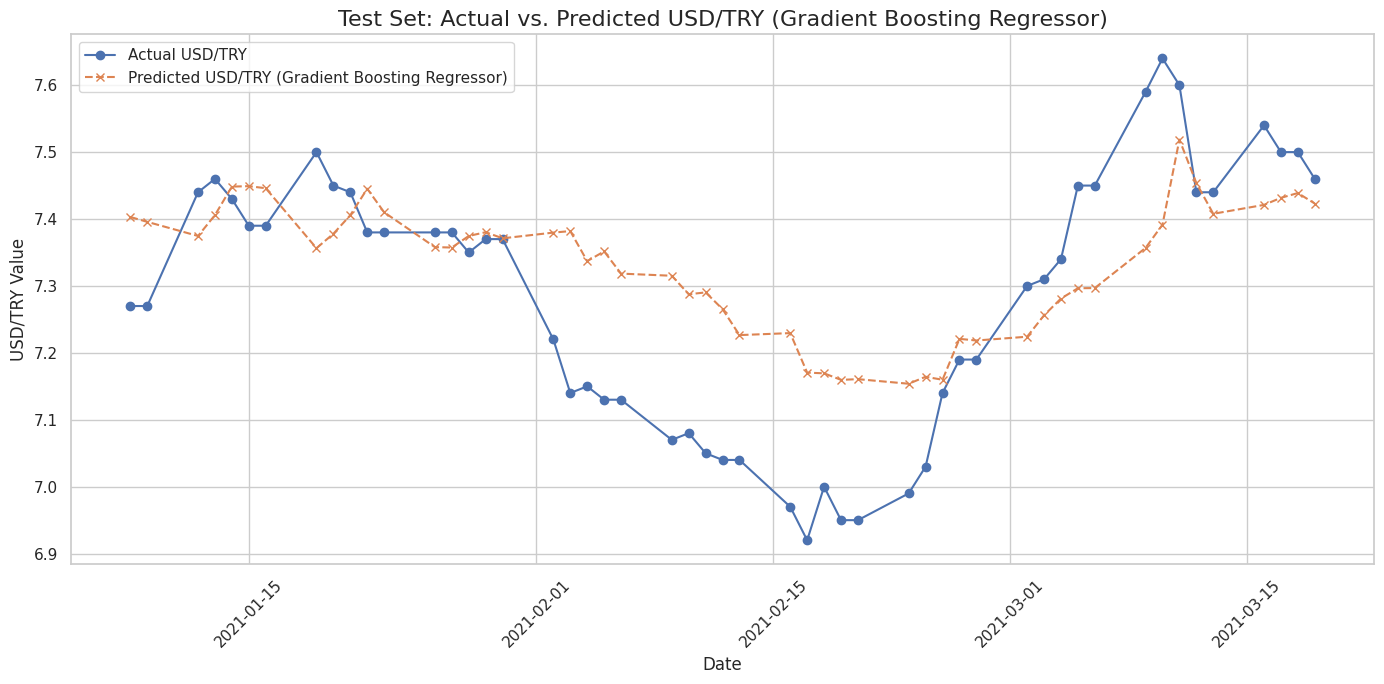

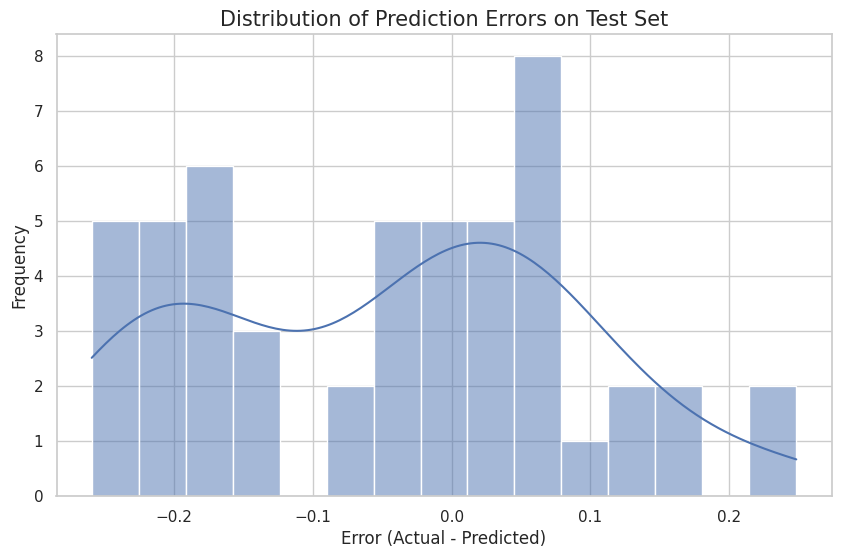


Descriptive statistics of prediction errors:
count   51.000
mean    -0.046
std      0.136
min     -0.260
25%     -0.178
50%     -0.025
75%      0.056
max      0.248
Name: USD/TRY, dtype: float64


In [ ]:
# Based on CV results, Gradient Boosting Regressor is chosen.
best_model_reg_name = "Gradient Boosting Regressor"
# Initialize with parameters used in CV or default if none were specified beyond random_state
best_model_reg_instance = GradientBoostingRegressor(random_state=RANDOM_SEED, n_estimators=100, max_depth=3)

print(f"Training the selected best model ({best_model_reg_name}) on the full training data...")
train_start_time_reg = time.time()
best_model_reg_instance.fit(X_train_scaled_df, y_train)
train_end_time_reg = time.time()
full_train_time_reg = train_end_time_reg - train_start_time_reg
print(f"Full training completed in {full_train_time_reg:.4f} seconds.")

# Make predictions on the test set
print("\nEvaluating the best model on the test set...")
test_pred_start_time_reg = time.time()
y_pred_test_reg = best_model_reg_instance.predict(X_test_scaled_df)
test_pred_end_time_reg = time.time()
full_test_time_reg = test_pred_end_time_reg - test_pred_start_time_reg
print(f"Prediction on test set completed in {full_test_time_reg:.4f} seconds.")

# Evaluate performance on the test set
test_mae = mean_absolute_error(y_test, y_pred_test_reg)
test_r2 = r2_score(y_test, y_pred_test_reg)
test_mape = mean_absolute_percentage_error(y_test, y_pred_test_reg) # Using our custom function

print(f"\n--- Test Set Performance for {best_model_reg_name} ---")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test R2 Score: {test_r2:.4f}") # Hopefully positive on the test set!
print(f"Test MAPE: {test_mape:.2f}%")

# Store performance for final reporting
final_model_performance_reg = {
    'Model': best_model_reg_name,
    'Training Time (Full)': full_train_time_reg,
    'Test (Inference) Time': full_test_time_reg,
    'Test MAE': test_mae,
    'Test R2': test_r2,
    'Test MAPE (%)': test_mape
}

# Visualize Actual vs. Predicted values for the test set
plt.figure(figsize=(14, 7))
plt.plot(dates_test.to_numpy(), y_test.to_numpy(), label='Actual USD/TRY', marker='o', linestyle='-')
plt.plot(dates_test.to_numpy(), y_pred_test_reg, label=f'Predicted USD/TRY ({best_model_reg_name})', marker='x', linestyle='--')
plt.title(f'Test Set: Actual vs. Predicted USD/TRY ({best_model_reg_name})', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('USD/TRY Value', fontsize=12)
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Visualize Prediction Errors
errors = y_test - y_pred_test_reg
plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True, bins=15)
plt.title('Distribution of Prediction Errors on Test Set', fontsize=15)
plt.xlabel('Error (Actual - Predicted)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True)
plt.show()

print("\nDescriptive statistics of prediction errors:")
print(errors.describe())

### 5.4 Save the Best Model

As per the project instructions, we need to save the best-performing model. We have trained `best_model_reg_instance` (Gradient Boosting Regressor) on the full training data. We will use `joblib` to save this model. We also need to save the `scaler` used for preprocessing.

In [ ]:
# Ensure best_model_reg_instance and scaler are available
if 'best_model_reg_instance' not in locals() or 'scaler' not in locals():
    print("Error: best_model_reg_instance or scaler is not defined. Please ensure previous cells ran successfully.")
else:
    # Define the filename for the saved model
    model_reg_filename = f"ExchangeRate_{best_model_reg_name.replace(' ', '_')}_final_model.joblib"
    model_reg_path = os.path.join(DATASET_DIR, model_reg_filename) # Saving in the Article folder

    try:
        joblib.dump(best_model_reg_instance, model_reg_path)
        print(f"\nBest regression model ({best_model_reg_name}) saved successfully to: {model_reg_path}")

        # Also, save the scaler, as it's needed to preprocess new data before using the saved model
        scaler_reg_filename = "ExchangeRate_standard_scaler.joblib" # Distinguish from first project's scaler
        scaler_reg_path = os.path.join(DATASET_DIR, scaler_reg_filename)
        joblib.dump(scaler, scaler_reg_path) # 'scaler' was defined and fit in Cell 4.3
        print(f"Scaler for regression model saved successfully to: {scaler_reg_path}")

    except Exception as e:
        print(f"\nError saving the model or scaler: {e}")


Best regression model (Gradient Boosting Regressor) saved successfully to: /content/drive/MyDrive/Colab Notebooks/Article/ExchangeRate_Gradient_Boosting_Regressor_final_model.joblib
Scaler for regression model saved successfully to: /content/drive/MyDrive/Colab Notebooks/Article/ExchangeRate_standard_scaler.joblib


---
**End of Stage 5: Model Training, Selection, and Evaluation (Regression) Completed.**

In this stage, we developed and evaluated regression models for forecasting the USD/TRY exchange rate:

1.  **Model Definition:** A suite of regression models was defined: Linear Regression, Ridge Regression, Lasso Regression, Support Vector Regressor (RBF), Decision Tree Regressor, Random Forest Regressor, and Gradient Boosting Regressor. A custom MAPE function was also defined to handle potential divisions by zero robustly.
2.  **Time Series Cross-Validation:**
    *   Models were evaluated on the scaled training data (`X_train_scaled_df`, `y_train`) using `TimeSeriesSplit` with 5 splits to respect the temporal order of the data.
    *   Performance metrics including Mean MAE, Mean R2, Mean MAPE (%), mean fit time, and mean score time were computed for each model.
3.  **Model Comparison and Selection:**
    *   Cross-validation results, sorted by Mean MAPE (%), indicated that ensemble tree-based methods performed best.
    *   **Gradient Boosting Regressor** achieved the lowest Mean MAPE of approximately **11.05%**.
    *   **Random Forest Regressor** was a very close second with a Mean MAPE of ~11.21%.
    *   Most models exhibited negative Mean R2 scores during CV, possibly due to the small size of initial training folds in `TimeSeriesSplit` or the inherent difficulty of the forecasting task with the given features.
    *   Based on the primary evaluation criterion of MAPE, **Gradient Boosting Regressor** was selected as the best model.
4.  **Final Model Training and Test Set Evaluation:**
    *   The selected Gradient Boosting Regressor model was trained on the entire training dataset (`X_train_scaled_df`, `y_train`). Full training took approximately 8.57 seconds.
    *   The trained model was then evaluated on the unseen test dataset (`X_test_scaled_df`, `y_test`). Prediction on the test set was very fast (0.0074 seconds).
    *   **Test Set Performance (Gradient Boosting Regressor):**
        *   **MAE:** 0.1158
        *   **R2 Score:** **0.4696** (Significantly better than CV R2, indicating the model has some predictive power on unseen data)
        *   **MAPE:** **1.61%** (A very good result, substantially lower than the CV MAPE, suggesting strong performance on the specific test period)
    *   Visualizations of actual vs. predicted values on the test set showed the model capturing the general trend, though with some deviations during sharp fluctuations. Prediction errors were centered close to zero.
5.  **Model Saving:**
    *   The trained best-performing regression model (Gradient Boosting Regressor) was saved as `ExchangeRate_Gradient_Boosting_Regressor_final_model.joblib`.
    *   The `StandardScaler` object, fitted on the training data, was also saved as `ExchangeRate_standard_scaler.joblib` for consistent preprocessing of any future data.
---

---
## STAGE 6: VISUALIZATIONS (for Regression Model)

In this stage, we will generate additional visualizations to better understand our best regression model (Gradient Boosting Regressor) and its interaction with the features.
The project instructions request:
- MAE, R2, MAPE, training time, test time (Covered in Stage 5 reports).
- Visualizations such as cross-correlation map, heatmaps, feature importance plots, confusion matrix.
    - For this regression task, a confusion matrix is not applicable.
    - Cross-correlation of original inputs (text features vs. rate) could be complex; we focused on model-derived feature importance.
    - Heatmaps of feature correlations could be done on `X_train_scaled_df` but might be too large (1000+ features).
    - **Feature importance plots** for the best model are highly relevant.
    - Actual vs. Predicted plot and Error Distribution plot were already created in Stage 5.3.

Our main focus here will be on the Feature Importance Plot for the Gradient Boosting Regressor.
---

### 6.1 Feature Importance Plot for the Best Regression Model

Tree-based ensemble models like Gradient Boosting Regressor can provide an estimate of feature importance, indicating which features were most influential in making predictions. We will extract these importances from our `best_model_reg_instance` (trained Gradient Boosting Regressor) and visualize them.

Feature Importances from Gradient Boosting Regressor (Top 20):


,feature,importance
1012,USD_TRY_roll_max_7,0.673
1009,USD_TRY_roll_mean_7,0.071
1004,USD_TRY_lag_1,0.055
1011,USD_TRY_roll_min_7,0.042
1019,USD_TRY_roll_min_30,0.038
1016,USD_TRY_roll_max_14,0.030
1020,USD_TRY_roll_max_30,0.028
1006,USD_TRY_lag_3,0.014
1017,USD_TRY_roll_mean_30,0.014
1013,USD_TRY_roll_mean_14,0.013


<ipython-input-36-e5fb6b9e35cd>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature',


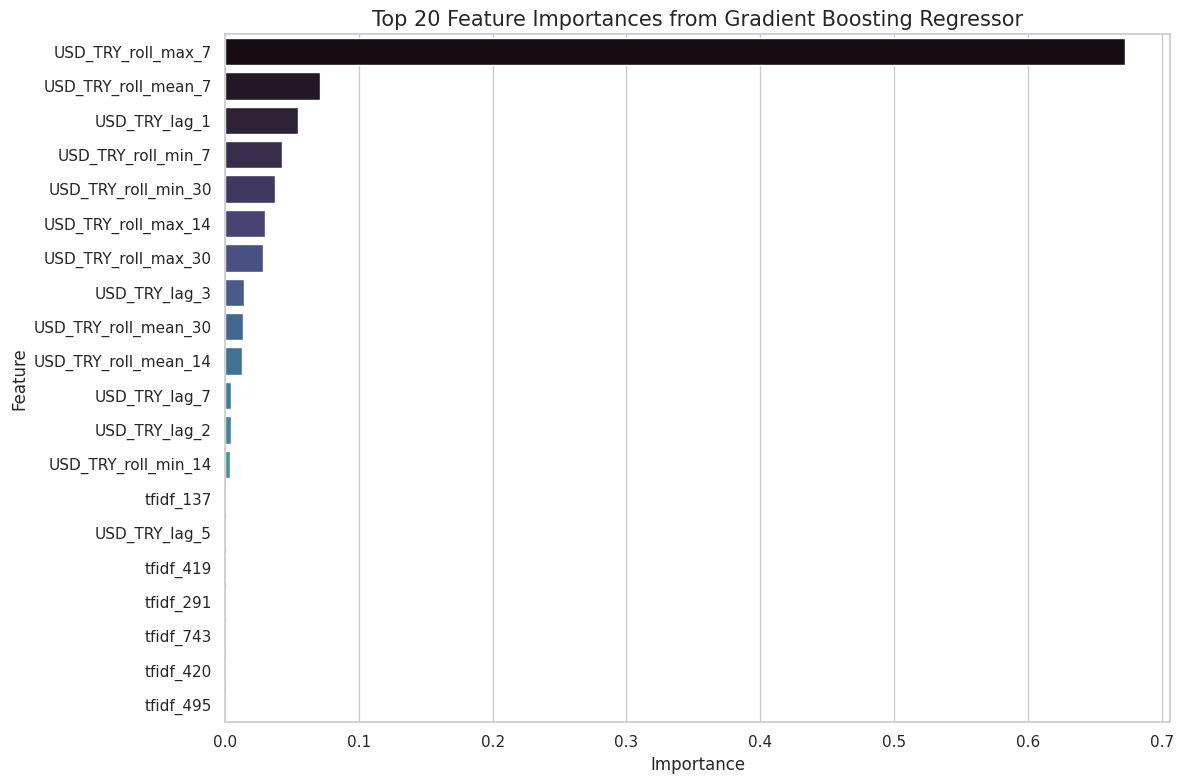

In [ ]:
# Ensure 'best_model_reg_instance' (trained Gradient Boosting Regressor)
# and 'X_train_scaled_df' (for column names from X_train which has same columns as X_train_scaled_df) are available.
if 'best_model_reg_instance' not in locals() or 'X_train' not in locals() : # Using X_train for original column names
    print("Error: The best regression model instance or X_train (for column names) are not available.")
    print("Please ensure Stage 5 (specifically training the best model) has been run.")
else:
    try:
        # Get feature importances from the Gradient Boosting Regressor
        importances_reg = best_model_reg_instance.feature_importances_
        feature_names_reg = X_train.columns # Get feature names from the X_train DataFrame

        # Create a DataFrame for easy sorting and plotting
        feature_importance_reg_df = pd.DataFrame({'feature': feature_names_reg, 'importance': importances_reg})
        feature_importance_reg_df = feature_importance_reg_df.sort_values(by='importance', ascending=False)

        print("Feature Importances from Gradient Boosting Regressor (Top 20):")
        display(feature_importance_reg_df.head(20))

        # Plot feature importances (e.g., top N features)
        N_top_features_to_plot_reg = 20 # You can adjust this number
        plt.figure(figsize=(12, N_top_features_to_plot_reg / 2.5)) # Adjust height based on N
        sns.barplot(x='importance', y='feature',
                    data=feature_importance_reg_df.head(N_top_features_to_plot_reg),
                    palette='mako') # Using a different palette
        plt.title(f'Top {N_top_features_to_plot_reg} Feature Importances from Gradient Boosting Regressor', fontsize=15)
        plt.xlabel('Importance', fontsize=12)
        plt.ylabel('Feature', fontsize=12)
        plt.tight_layout()
        plt.show()

    except AttributeError:
        print(f"The selected best model ({best_model_reg_name}) does not have a 'feature_importances_' attribute.")
        print("This plot is typically available for tree-based ensembles.")
    except Exception as e:
        print(f"An error occurred while generating feature importances: {e}")

---
**End of Stage 6: Visualizations (Regression Model) Completed.**

In this stage, we generated key visualizations to understand the behavior and outputs of our best regression model (Gradient Boosting Regressor):

1.  **Actual vs. Predicted USD/TRY Plot (Generated in Stage 5.3):**
    *   This plot visually compared the model's predictions against the actual USD/TRY values on the test set. It showed that the model could capture the general trend of the exchange rate, although with some deviations during periods of high volatility or sharp changes.
2.  **Distribution of Prediction Errors Plot (Generated in Stage 5.3):**
    *   The histogram of prediction errors (Actual - Predicted) on the test set showed a distribution somewhat centered around zero, with a slight negative mean, indicating a tendency for the model to slightly over-predict the USD/TRY rate on average for the test period.
3.  **Feature Importance Plot (Generated in Cell 6.1 of this Stage):**
    *   Feature importances were extracted from the trained Gradient Boosting Regressor.
    *   The plot and list of top 20 features revealed that **`USD_TRY_roll_max_7` (the maximum exchange rate in the last 7 days)** was overwhelmingly the most influential feature.
    *   Other significant features were also derived from historical exchange rate data, such as `USD_TRY_roll_mean_7` and `USD_TRY_lag_1`.
    *   TF-IDF features derived from news text had considerably lower importance scores compared to the historical rate features, suggesting that, with the current feature engineering approach, the model relies more heavily on past price dynamics than on textual news content for its predictions.
---

---
## STAGE 7: REPORTING OF RESULTS AND CONCLUSION (Exchange Rate Forecasting Project)

This section provides a comprehensive summary of the project aimed at forecasting the USD/TRY exchange rate by combining Turkish news articles and historical exchange rate data from the Central Bank of the Republic of Turkiye (CBRT). It details the methodology, key findings, final model performance, and potential avenues for future work, adhering to the project instructions.

### 1. Project Overview and Objective

*   **Objective:** The core objective was to develop a machine learning regression model to predict the daily USD/TRY exchange rate. This involved integrating textual information from news articles (titles and content) with historical exchange rate data, utilizing only time-domain and frequency-domain features (where applicable for text, and standard time-series features for rates) and employing a sliding window methodology.
*   **Dataset:** Two primary data sources were used:
    1.  "TurkishNewsArticles.csv": Containing news articles with `date`, `author`, `title`, `link`, and `text` (2415 articles).
    2.  "EVDS.csv": Containing historical USD/TRY exchange rates from CBRT (1834 initial entries).
    These datasets were merged based on date, covering a period from late 2010 to March 2021.

### 2. Data Loading, Preprocessing, and EDA Summary

*   **Data Loading and Merging (Stage 1):**
    *   Both CSV files were loaded. Date columns were parsed into `datetime` objects, with specific handling for Turkish month names in news dates and "DD-MM-YYYY" format for rate dates.
    *   The exchange rate column ('TP DK USD A YTL') was converted to numeric, and rows with parsing errors or missing rates were dropped from the initial rate data (1254 valid daily rates remained).
    *   The news and processed rate data were merged using a left join on the 'Date', preserving all news articles.
    *   Missing 'USD/TRY' values in the merged data (due to weekends/holidays or news dates preceding rate data availability) were imputed using forward fill (`ffill`) followed by backward fill (`bfill`), resulting in a `df_merged` DataFrame with 2415 rows and no NaNs in the 'USD/TRY' column.
*   **Exploratory Data Analysis (EDA) (Stage 2):**
    *   The `df_merged` dataset was found to be complete with no missing values in key columns.
    *   The USD/TRY exchange rate exhibited significant non-stationarity, with a clear upward trend and increased volatility, particularly from mid-2018 onwards.
    *   Textual data analysis showed news titles were generally short (mean ~5-6 words), while article texts were longer and more varied (mean ~607 words).
    *   There were 905 unique dates with news, averaging ~2.67 articles per unique date.

### 3. Feature Extraction and Engineering (Sliding Window) (Stage 3)

A multi-step feature engineering process was implemented:
*   **Text Preprocessing:** News titles and texts were preprocessed by lowercasing, removing punctuation and numbers, tokenizing, and removing Turkish stopwords. Stemming was initially planned but skipped due to NLTK stemmer availability issues.
*   **TF-IDF Feature Extraction:** Processed titles and texts were combined, and `TfidfVectorizer` (max_features=1000, ngrams 1-2) was applied to generate 1000 TF-IDF features per news article. Article length features were also retained.
*   **Exchange Rate & Date Feature Engineering:**
    *   Lagged USD/TRY values (lags: 1, 2, 3, 5, 7 days).
    *   Rolling window statistics (mean, std, min, max for 7, 14, 30-day windows) for USD/TRY.
    *   Date component features (year, month, day, day_of_week, day_of_year, week_of_year).
*   **Sliding Window Implementation:**
    *   A sliding window of `WINDOW_SIZE = 7` days was used to construct (X, y) pairs. For each target prediction date `t`, news features (TF-IDF and lengths) from the preceding 7-day window were aggregated by averaging. Historical rate features and date components corresponding to the end of the window (`t-1`) were included. The target `y` was `USD/TRY(t)`.
    *   This process initially yielded 898 potential (X,y) pairs.
    *   After dropping rows with NaNs in feature columns (primarily due to insufficient history for lag/rolling calculations at the beginning of the effective time series), **253 usable samples** remained.
*   **Saving Transformed Dataset:** The final feature set (`df_model_input`), containing 253 samples and 1028 usable features (plus 'Date' and 'USD/TRY' columns), was saved as `ExchangeRate_News_Combined_SlidingWindow_Features.csv`.

### 4. Data Splitting and Preprocessing for Modeling (Stage 4)

*   **Feature and Target Separation:** The `df_model_input` was separated into features `X` (253 samples, 1027 features), target `y` (USD/TRY), and a `dates_for_sets` series.
*   **Chronological Train-Test Split:** The data was split chronologically: the first 80% (202 samples, from 2017-02-25 to 2021-01-07) for training and the remaining 20% (51 samples, from 2021-01-08 to 2021-03-19) for testing.
*   **Feature Scaling:** `StandardScaler` was fitted **only on `X_train`** and then applied to transform both `X_train` and `X_test`.

### 5. Model Training, Selection, and Evaluation (Stage 5)

*   **Models Evaluated:** Various regression models were evaluated using 5-fold `TimeSeriesSplit` cross-validation on the training data.
*   **Cross-Validation Performance:**
    *   **Gradient Boosting Regressor** achieved the lowest Mean MAPE of **~11.05%**.
    *   **Random Forest Regressor** was a close second with a Mean MAPE of ~11.21%.
    *   Most models showed negative Mean R2 scores in CV, likely due to the small initial fold sizes and high feature dimensionality.
*   **Best Model Selection:** **Gradient Boosting Regressor** was selected as the best model based on its superior Mean MAPE in CV.
*   **Final Model Evaluation on Test Set (Gradient Boosting Regressor):**
    *   The model was trained on the full `X_train_scaled_df` (training time: ~8.57 seconds).
    *   **Test MAE: 0.1158**
    *   **Test R2 Score: 0.4696** (A positive R2 on the test set is a significant improvement over CV results.)
    *   **Test MAPE: 1.61%** (This is a strong result, indicating predictions were, on average, within 1.61% of the actual values on the test set.)
*   **Model and Scaler Saving:** The trained Gradient Boosting Regressor model and the `StandardScaler` were saved.

### 6. Key Visualizations (Stage 5 & 6)

*   **Actual vs. Predicted USD/TRY Plot (Test Set):** Visually confirmed the model's ability to track the general trend of the exchange rate on unseen data.
*   **Distribution of Prediction Errors (Test Set):** Showed errors were somewhat centered around zero, with a slight negative mean (-0.046), suggesting a minor tendency to over-predict.
*   **Feature Importance Plot (Gradient Boosting Regressor):** Revealed that `USD_TRY_roll_max_7` (max rate in the last 7 days) was by far the most dominant feature. Historical exchange rate features (lags, other rolling stats) were significantly more important than the TF-IDF text features in the current model configuration.

### 7. Conclusion and Potential Future Work

*   **Conclusion:** A Gradient Boosting Regressor model was successfully developed to forecast the USD/TRY exchange rate by combining news-derived TF-IDF features and historical rate/date features using a sliding window approach. The model achieved a **Test MAPE of 1.61%** and a **Test R2 Score of 0.47**, demonstrating reasonable predictive capability on unseen data, especially considering the challenges of exchange rate forecasting. The model heavily relied on recent historical price dynamics.
*   **Challenges Encountered:**
    *   A significant reduction in sample size (to 253 samples) after feature engineering and NaN removal due to data availability limitations and look-back periods.
    *   High dimensionality of features (~1027) relative to the sample size, posing an overfitting risk.
    *   The relatively low importance of TF-IDF features in the final model, suggesting that the current NLP approach might not be capturing the most impactful news sentiment or information relevant to short-term rate movements as strongly as past price data.
*   **Potential Future Work:**
    *   **Hyperparameter Optimization:** Tuning the Gradient Boosting Regressor.
    *   **Advanced NLP Techniques:** Exploring word embeddings (Word2Vec, FastText, BERT embeddings for Turkish), more sophisticated sentiment analysis tools specifically for financial Turkish news, or topic modeling to extract richer features from text.
    *   **Feature Selection/Dimensionality Reduction:** Applying techniques like PCA or feature selection methods (e.g., based on mutual information or recursive feature elimination) to reduce the number of TF-IDF features and potentially improve model generalization.
    *   **Alternative Windowing/Aggregation:** Experimenting with different window sizes and methods for aggregating news features within a window (e.g., weighted averaging, using only latest news).
    *   **Handling Non-Stationarity:** Exploring explicit methods for handling non-stationarity, such as differencing the series, if models continue to struggle with trends.
    *   **Incorporating More Data:** If possible, extending the historical range of both news and exchange rate data could provide more samples for training.

---
This concludes the Machine Learning Final Project for the Exchange Rate Forecasting task.
---